# COMP5318 Assignment 2: Image Classification

### Group number: A2 Group 54  , SID1: 500482094 , SID2: 500178278 

## Setup and dependencies
In this section, we will list and set up all required libraries/dependencies and plotting environment. 

In [42]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from scikeras.wrappers import KerasClassifier
from datetime import datetime
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np
from sklearn import metrics

keras.backend.clear_session()
tf.random.set_seed(42)

## Data loading, preprocessing, and exploration

In this section, we load the fashion mnist data, and used the PCA and normalization method for pre-processing and plot some examples for better understand the datasets

The documentation for the data loading function can be accessed [here](https://keras.io/api/datasets/fashion_mnist/).

### Data Loading

In [13]:
# Load the Fashion-MNIST dataset training and test sets as numpy arrays
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [14]:
# An ordered list of the class names
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"
              ]

### Preprocessing

Normalization will be appied for the MLP training and PCA

In [15]:
# Normalization
X_train_nor = X_train / 255.0
X_test_nor = X_test / 255.0

In [16]:
# Validation data
X_train_valid, X_valid, y_train_valid, y_valid = train_test_split(X_train_nor, y_train, train_size=0.9, random_state = 42)

We will use PCA method to reduce the dimensions. Moreover, we use the graph to show the curve to find the proper percentage of variance

In [17]:
# PCA 
X_train_pca = X_train_valid.reshape(X_train_valid.shape[0], -1)
X_test_pca = X_test_nor.reshape(X_test.shape[0], -1)

pca = PCA()
pca.fit(X_train_pca)
cumsum = np.cumsum(pca.explained_variance_ratio_)

The elbow is at 100-200 dimensions, so the graph suggest that if we chose 100-200 dimensions we wouldn't lose too much explained variance

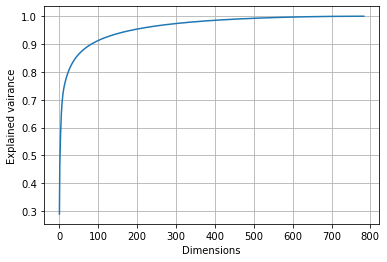

In [18]:
# Draw the dimensions graph.
plt.figure(figsize=(6,4))
plt.plot(cumsum)
plt.xlabel("Dimensions")
plt.ylabel("Explained vairance")
plt.grid(True)
plt.show()

The following code transform the train data using PCA method

In [19]:
# Transform the data using PCA method
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)
X_test_pca.shape

(10000, 187)

In order to reduce the runtime in the tune hyperparameter process, we only choose the first 1000 examples

In [20]:
# Sublist of the original data for finding the parameter
X_train_valid_sub = X_train_valid[:1000]
X_test_nor_sub = X_test_nor[:1000]

y_train_valid_sub = y_train_valid[:1000]
y_test_sub = y_test[:1000]

X_train_pca_sub = X_train_pca[:1000]
X_test_pca_sub = X_test_pca[:1000]

### Data exploration

We will visualise some examples to better understand the datasets

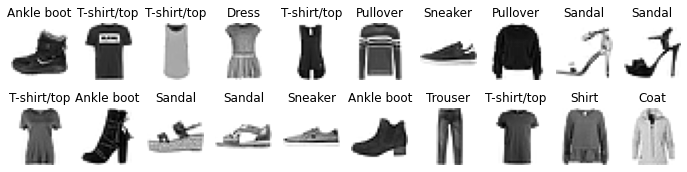

In [21]:
def plot_examples(X_train, y_train, n_rows=4, n_cols=10):
    """Plot a grid of MNIST examples of a specified size."""
    
    # Change the font size
    NORMAL_SIZE = 10
    plt.rc('font', size=NORMAL_SIZE)
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.5))
    
    # The first 20 samples
    for i in range(20):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(X_train[i], cmap="binary")
        plt.title(class_names[y_train[i]])
        plt.axis("off")
        
    plt.show()
plot_examples(X_train, y_train)

In [22]:
# Check the format of the label by looking at the first five examples
print(y_train_valid[0:5])
# List all unique labels in the training set
print(np.unique(y_train_valid))

[5 2 9 0 5]
[0 1 2 3 4 5 6 7 8 9]


## Algorithm design and setup

### K-nearest neighbors (KNN)

we will use the 10-fold cross validation as our validation method. We also use the random state 42 to make sure our result is stable.

In [23]:
cvKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42)

In [24]:
def grid_search_knn(function, x_data, y_data, parameter_grid):
    clf = GridSearchCV(function, parameter_grid, cv=cvKFold)
    print("Funtion name: KNN")
    clf.fit(x_data, y_data)
    print("The best parameter is: ")
    print(clf.best_params_)
    return clf

In [25]:
def tune_knn(parameter_grid, x_data, y_data):
    clf = grid_search_knn(KNeighborsClassifier(), x_data, y_data, parameter_grid)
    n_splits  = clf.n_splits_ # number of splits of training data
    n_iter = pd.DataFrame(clf.cv_results_).shape[0] # Iterations per each split
    
    # Change the font size
    MIDDLE_SIZE = 12
    plt.rc('font', size=MIDDLE_SIZE)
    figure, axis = plt.subplots(1, 2, figsize = (12,8))
    
    # Draw the graph
    axis[0].plot(range(len(parameter_grid["n_neighbors"])), clf.cv_results_['mean_test_score'])
    axis[0].set_xlabel("N neighbors")
    axis[0].set_ylabel("Accuracy")
    axis[0].set_xticks(range(len(parameter_grid["n_neighbors"])), parameter_grid["n_neighbors"])
    axis[0].set_title("Accuracy Comparson")
    axis[0].grid(True)
    
    # The second plot
    axis[1].plot(range(len(parameter_grid["n_neighbors"])), clf.cv_results_['mean_fit_time'] * n_splits * n_iter)
    axis[1].set_xlabel("N neighbors")
    axis[1].set_ylabel("Runtime (s)")
    axis[1].set_xticks(range(len(parameter_grid["n_neighbors"])), parameter_grid["n_neighbors"])
    axis[1].set_title("Runtime Comparson")
    axis[1].set_autoscale_on(True)
    axis[1].grid(True) 
    
    plt.grid(True)
    plt.show()
    return clf

### Fully connected neural network (MLP)

we made a MLP that contains 3 hidden layers, 100 neurons for each layers. The hyperparameter is activation_function and learning rate.

In [26]:
def build_mlp(n_hidden_layer=3, n_hidden_neurons=100, activation_function="relu", input_shape=(28,28)):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = input_shape))
    
    for layer in range(n_hidden_layer):
        model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))
    model.add(keras.layers.Dense(len(class_names), activation="softmax"))
    return model

In [27]:
mlp = KerasClassifier(build_mlp,
                    n_hidden_layer=2,
                    n_hidden_neurons=50,
                    activation_function="relu",
                    loss="sparse_categorical_crossentropy",
                    optimizer="sgd",
                    optimizer__lr=0.01,
                    metrics=["accuracy"])

In [28]:
def grid_search_mlp(function, x_data, y_data, parameter_grid):
    clf = GridSearchCV(function, parameter_grid, cv=cvKFold)
    print("Funtion name: MLP")
    clf.fit(X=x_data, y=y_data, epochs=20)
    print("The best parameter is: ")
    print(clf.best_params_)
    return clf

In [29]:
def tune_mlp(parameter_grid, x_data, y_data):
    clf = grid_search_mlp(mlp, x_data, y_data, parameter_grid)
    return clf 

### Convolutional neural network (CNN)

we made a CNN model that is similar as the VGG 16. we used 2Con2D + MaxPool + 2Con2D + MaxPool + 3Con2D + MaxPool + 3Con2D + MaxPool + 3Dense as our model. The hyperparameter is kernel_size and strides.

In [30]:
# This is a simple version of VGG16 model

def build_cnn(n_hidden_layer=4, strides=(1, 1), kernel_size = (2, 2), activation_function="relu", input_shape=(28, 28, 1)):
    model = keras.models.Sequential()
    model.add(keras.Input(shape = input_shape))
    
    model.add(keras.layers.Conv2D(64, padding="same", kernel_size=kernel_size, activation="relu"))
    model.add(keras.layers.Conv2D(64, padding="same", kernel_size=kernel_size, activation="relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides = strides))
    
    model.add(keras.layers.Conv2D(128, padding="same", kernel_size=(2, 2), activation="relu"))
    model.add(keras.layers.Conv2D(128, padding="same", kernel_size=(2, 2), activation="relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(keras.layers.Conv2D(256, padding="same", kernel_size=(2, 2), activation="relu"))
    model.add(keras.layers.Conv2D(256, padding="same", kernel_size=(2, 2), activation="relu"))
    model.add(keras.layers.Conv2D(256, padding="same", kernel_size=(2, 2), activation="relu"))    
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(keras.layers.Conv2D(512, padding="same", kernel_size=(2, 2), activation="relu"))
    model.add(keras.layers.Conv2D(512, padding="same", kernel_size=(2, 2), activation="relu"))
    model.add(keras.layers.Conv2D(512, padding="same", kernel_size=(2, 2), activation="relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(4096, activation = "relu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(4096, activation = "relu"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(len(class_names), activation = "softmax"))
    return model

In [31]:
cnn = KerasClassifier(build_cnn,
                    n_hidden_layer=2,
                    strides=(1, 1),
                    kernel_size = (2, 2),
                    activation_function="relu",
                    loss="sparse_categorical_crossentropy",
                    optimizer="adam",
                    optimizer__lr=0.01,
                    metrics=["accuracy"])

In [32]:
def grid_search_cnn(function, x_data, y_data, parameter_grid):
    clf = GridSearchCV(function, parameter_grid, cv=cvKFold)
    print("Funtion name: CNN")
    clf.fit(X=x_data, y=y_data, epochs=20, batch_size = 128, validation_data=(X_valid, y_valid))
    print("The best parameter is: ")
    print(clf.best_params_)
    return clf

In [33]:
def tune_cnn(parameter_grid, x_data, y_data):
    clf = grid_search_cnn(cnn, x_data, y_data, parameter_grid)
    return clf 

## Hyperparameter tuning

### K-nearest neighbors (KNN)

We are looking for the best parameter for KNN. Moreover, we plot the graph to demonstrate the accuracy between different parameter.  
Hyperparameter: Number of neighbors.

Funtion name: KNN
The best parameter is: 
{'n_neighbors': 6}


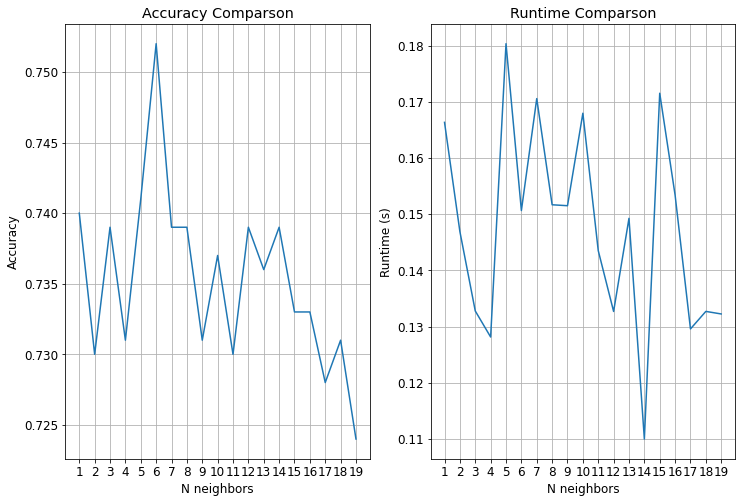

In [64]:
knn_parameter_grid = {"n_neighbors": np.arange(1, 20)}
knn_model = tune_knn(knn_parameter_grid, X_train_pca_sub, y_train_valid_sub)
knn_param = knn_model.best_params_

In [65]:
# This is the mean of the fitting time for each hyperparameter combination

mean_fit_time= knn_model.cv_results_['mean_fit_time']
n_splits  = knn_model.n_splits_ # number of splits of training data
n_iter = pd.DataFrame(knn_model.cv_results_).shape[0] # Iterations per each split

### Fully connected neural network (MLP)

We are looking for the best parameter for MLP. Moreover, we plot the graph to demonstrate the accuracy between different parameter.  
Hyperparameter: Activation function and leraning rate.

In [37]:
mlp_parameter_grid = {
    "activation_function": ["relu", "sigmoid", None],
    "optimizer__lr": [0.0001, 0.001, 0.01, 0.1]
}
mlp_model = tune_mlp(mlp_parameter_grid, x_data=X_train_valid_sub, y_data=y_train_valid_sub)
mlp_param = mlp_model.best_params_

Funtion name: MLP
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Epoch 1/20
29/29 [==============================] - 2s 3ms/step - loss: 2.3361 - accuracy: 0.0833
Epoch 2/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3312 - accuracy: 0.0867
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3264 - accuracy: 0.0900
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3217 - accuracy: 0.0889
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3172 - accuracy: 0.0889
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3130 - accuracy: 0.0889
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3087 - accuracy: 0.0956
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3047 - accuracy: 0.0978
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3009 - accuracy: 0.1000
Epoch 10/20
29/29 [==================

29/29 [==============================] - 0s 2ms/step - loss: 2.3431 - accuracy: 0.0944
Epoch 2/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3397 - accuracy: 0.0967
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3363 - accuracy: 0.1000
Epoch 4/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3328 - accuracy: 0.1033
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3296 - accuracy: 0.1089
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3264 - accuracy: 0.1089
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3233 - accuracy: 0.1100
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3202 - accuracy: 0.1111
Epoch 9/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3172 - accuracy: 0.1144
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3143 - accuracy: 0.1189
Epoch 11/20
29/29 [===========

29/29 [==============================] - 0s 1ms/step - loss: 2.4124 - accuracy: 0.0778
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4065 - accuracy: 0.0822
Epoch 4/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4006 - accuracy: 0.0833
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3950 - accuracy: 0.0844
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3895 - accuracy: 0.0856
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3841 - accuracy: 0.0878
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3790 - accuracy: 0.0878
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3738 - accuracy: 0.0878
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3688 - accuracy: 0.0967
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3641 - accuracy: 0.0989
Epoch 12/20
29/29 [==========

29/29 [==============================] - 0s 2ms/step - loss: 2.2881 - accuracy: 0.2056
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2415 - accuracy: 0.2233
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2021 - accuracy: 0.2456
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1680 - accuracy: 0.2567
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1371 - accuracy: 0.2800
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1084 - accuracy: 0.3089
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 2.0805 - accuracy: 0.3400
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 2.0542 - accuracy: 0.3600
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 2.0281 - accuracy: 0.3778
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 2.0021 - accuracy: 0.3933
Epoch 13/20
29/29 [=========

29/29 [==============================] - 0s 2ms/step - loss: 2.2451 - accuracy: 0.1922
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2213 - accuracy: 0.2222
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1986 - accuracy: 0.2500
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1764 - accuracy: 0.2811
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1550 - accuracy: 0.3044
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1346 - accuracy: 0.3189
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1150 - accuracy: 0.3344
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 2.0950 - accuracy: 0.3444
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 2.0756 - accuracy: 0.3556
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 2.0560 - accuracy: 0.3567
Epoch 14/20
29/29 [========

29/29 [==============================] - 0s 2ms/step - loss: 1.6227 - accuracy: 0.5044
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 1.4807 - accuracy: 0.5644
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 1.3554 - accuracy: 0.6011
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 1.2514 - accuracy: 0.6133
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 1.1697 - accuracy: 0.6267
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 1.1021 - accuracy: 0.6467
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 1.0460 - accuracy: 0.6478
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 1.0029 - accuracy: 0.6467
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9646 - accuracy: 0.6733
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9247 - accuracy: 0.6756
Epoch 15/20
29/29 [=======

29/29 [==============================] - 0s 2ms/step - loss: 1.4497 - accuracy: 0.5433
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 1.3304 - accuracy: 0.5933
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 1.2352 - accuracy: 0.6233
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 1.1539 - accuracy: 0.6367
Epoch 10/20
29/29 [==============================] - 0s 1ms/step - loss: 1.0995 - accuracy: 0.6356
Epoch 11/20
29/29 [==============================] - 0s 1ms/step - loss: 1.0366 - accuracy: 0.6589
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9952 - accuracy: 0.6589
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9662 - accuracy: 0.6567
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9245 - accuracy: 0.6811
Epoch 15/20
29/29 [==============================] - 0s 1ms/step - loss: 0.9059 - accuracy: 0.7000
Epoch 16/20
29/29 [======

29/29 [==============================] - 0s 2ms/step - loss: 1.3354 - accuracy: 0.6344
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 1.2311 - accuracy: 0.6444
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 1.1571 - accuracy: 0.6456
Epoch 10/20
29/29 [==============================] - 0s 1ms/step - loss: 1.0853 - accuracy: 0.6600
Epoch 11/20
29/29 [==============================] - 0s 1ms/step - loss: 1.0237 - accuracy: 0.6722
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9739 - accuracy: 0.6900
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9358 - accuracy: 0.7089
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9034 - accuracy: 0.7022
Epoch 15/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8854 - accuracy: 0.7078
Epoch 16/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8456 - accuracy: 0.7267
Epoch 17/20
29/29 [=====

29/29 [==============================] - 0s 1ms/step - loss: 0.6680 - accuracy: 0.7633
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 0.6187 - accuracy: 0.7711
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 0.6978 - accuracy: 0.7544
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.7667
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5243 - accuracy: 0.8178
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5245 - accuracy: 0.8189
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4881 - accuracy: 0.8311
Epoch 15/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.8300
Epoch 16/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4167 - accuracy: 0.8467
Epoch 17/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4090 - accuracy: 0.8556
Epoch 18/20
29/29 [====

29/29 [==============================] - 0s 2ms/step - loss: 0.6668 - accuracy: 0.7511
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.7533
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5613 - accuracy: 0.7922
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5355 - accuracy: 0.7933
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5198 - accuracy: 0.8100
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4832 - accuracy: 0.8100
Epoch 15/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5370 - accuracy: 0.8100
Epoch 16/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.8222
Epoch 17/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4227 - accuracy: 0.8522
Epoch 18/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4673 - accuracy: 0.8233
Epoch 19/20
29/29 [===

29/29 [==============================] - 0s 1ms/step - loss: 2.4595 - accuracy: 0.0989
Epoch 11/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4581 - accuracy: 0.0989
Epoch 12/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4567 - accuracy: 0.0989
Epoch 13/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4553 - accuracy: 0.0989
Epoch 14/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4538 - accuracy: 0.0989
Epoch 15/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4525 - accuracy: 0.0989
Epoch 16/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4511 - accuracy: 0.0989
Epoch 17/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4498 - accuracy: 0.0989
Epoch 18/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4485 - accuracy: 0.0989
Epoch 19/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4471 - accuracy: 0.0989
Epoch 20/20
4/4 [=====

29/29 [==============================] - 0s 1ms/step - loss: 2.5699 - accuracy: 0.1111
Epoch 12/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5671 - accuracy: 0.1111
Epoch 13/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5642 - accuracy: 0.1111
Epoch 14/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5614 - accuracy: 0.1111
Epoch 15/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5586 - accuracy: 0.1111
Epoch 16/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5558 - accuracy: 0.1111
Epoch 17/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5531 - accuracy: 0.1111
Epoch 18/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5503 - accuracy: 0.1111
Epoch 19/20
29/29 [==============================] - 0s 2ms/step - loss: 2.5477 - accuracy: 0.1111
Epoch 20/20
4/4 [==============================] - 0s 997us/step
Epoch 1/20
29/29 [==============================] - 0s 2

29/29 [==============================] - 0s 1ms/step - loss: 2.4732 - accuracy: 0.0833
Epoch 13/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4715 - accuracy: 0.0833
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4698 - accuracy: 0.0833
Epoch 15/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4681 - accuracy: 0.0833
Epoch 16/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4664 - accuracy: 0.0833
Epoch 17/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4647 - accuracy: 0.0833
Epoch 18/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4631 - accuracy: 0.0833
Epoch 19/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4615 - accuracy: 0.0833
Epoch 20/20
4/4 [==============================] - 0s 997us/step
Epoch 1/20
29/29 [==============================] - 0s 2ms/step - loss: 2.5363 - accuracy: 0.0833
Epoch 2/20
29/29 [==============================] - 0s 2m

29/29 [==============================] - 0s 2ms/step - loss: 2.3133 - accuracy: 0.0844
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3112 - accuracy: 0.0844
Epoch 15/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3092 - accuracy: 0.0844
Epoch 16/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3074 - accuracy: 0.0844
Epoch 17/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3060 - accuracy: 0.0844
Epoch 18/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3042 - accuracy: 0.0856
Epoch 19/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3029 - accuracy: 0.0900
Epoch 20/20
4/4 [==============================] - 0s 997us/step
Epoch 1/20
29/29 [==============================] - 0s 2ms/step - loss: 2.5317 - accuracy: 0.1111
Epoch 2/20
29/29 [==============================] - 0s 2ms/step - loss: 2.5085 - accuracy: 0.1111
Epoch 3/20
29/29 [==============================] - 0s 2ms

29/29 [==============================] - 0s 2ms/step - loss: 2.3838 - accuracy: 0.1022
Epoch 15/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3748 - accuracy: 0.1022
Epoch 16/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3668 - accuracy: 0.1022
Epoch 17/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3595 - accuracy: 0.1022
Epoch 18/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3533 - accuracy: 0.1022
Epoch 19/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3475 - accuracy: 0.1022
Epoch 20/20
4/4 [==============================] - 0s 1ms/step
Epoch 1/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4271 - accuracy: 0.0978
Epoch 2/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4157 - accuracy: 0.0978
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4059 - accuracy: 0.0978
Epoch 4/20
29/29 [==============================] - 0s 2ms/st

29/29 [==============================] - 0s 1ms/step - loss: 2.2445 - accuracy: 0.2511
Epoch 16/20
29/29 [==============================] - 0s 1ms/step - loss: 2.2399 - accuracy: 0.2433
Epoch 17/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2354 - accuracy: 0.2700
Epoch 18/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2307 - accuracy: 0.2856
Epoch 19/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2255 - accuracy: 0.3078
Epoch 20/20
4/4 [==============================] - 0s 998us/step
Epoch 1/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4036 - accuracy: 0.1444
Epoch 2/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3448 - accuracy: 0.0967
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3160 - accuracy: 0.0878
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3023 - accuracy: 0.1067
Epoch 5/20
29/29 [==============================] - 0s 2ms/s

29/29 [==============================] - 0s 2ms/step - loss: 2.2400 - accuracy: 0.2556
Epoch 17/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2357 - accuracy: 0.2433
Epoch 18/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2313 - accuracy: 0.2544
Epoch 19/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2265 - accuracy: 0.3367
Epoch 20/20
4/4 [==============================] - 0s 1ms/step
Epoch 1/20
29/29 [==============================] - 0s 2ms/step - loss: 2.4697 - accuracy: 0.0767
Epoch 2/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3765 - accuracy: 0.0589
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3307 - accuracy: 0.0744
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3082 - accuracy: 0.0811
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2937 - accuracy: 0.0956
Epoch 6/20
29/29 [==============================] - 0s 2ms/step

29/29 [==============================] - 0s 1ms/step - loss: 2.2241 - accuracy: 0.3511
Epoch 18/20
29/29 [==============================] - 0s 1ms/step - loss: 2.2193 - accuracy: 0.3522
Epoch 19/20
29/29 [==============================] - 0s 1ms/step - loss: 2.2149 - accuracy: 0.4211
Epoch 20/20
4/4 [==============================] - 0s 997us/step
Epoch 1/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3930 - accuracy: 0.1011
Epoch 2/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3384 - accuracy: 0.1267
Epoch 3/20
29/29 [==============================] - 0s 3ms/step - loss: 2.3135 - accuracy: 0.1144
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3017 - accuracy: 0.1133
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2951 - accuracy: 0.1156
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2901 - accuracy: 0.0867
Epoch 7/20
29/29 [==============================] - 0s 2ms/ste

29/29 [==============================] - 0s 2ms/step - loss: 1.1960 - accuracy: 0.6122
Epoch 19/20
29/29 [==============================] - 0s 2ms/step - loss: 1.1598 - accuracy: 0.6200
Epoch 20/20
4/4 [==============================] - 0s 997us/step
Epoch 1/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3105 - accuracy: 0.1122
Epoch 2/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2646 - accuracy: 0.1444
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: 2.2166 - accuracy: 0.2078
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1570 - accuracy: 0.2700
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 2.0816 - accuracy: 0.3344
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 1.9803 - accuracy: 0.3767
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 1.8642 - accuracy: 0.4578
Epoch 8/20
29/29 [==============================] - 0s 2ms/step

29/29 [==============================] - 0s 1ms/step - loss: 1.1465 - accuracy: 0.6244
Epoch 20/20
4/4 [==============================] - 0s 891us/step
Epoch 1/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3327 - accuracy: 0.1011
Epoch 2/20
29/29 [==============================] - 0s 1ms/step - loss: 2.2639 - accuracy: 0.1533
Epoch 3/20
29/29 [==============================] - 0s 1ms/step - loss: 2.2201 - accuracy: 0.2311
Epoch 4/20
29/29 [==============================] - 0s 1ms/step - loss: 2.1622 - accuracy: 0.2511
Epoch 5/20
29/29 [==============================] - 0s 1ms/step - loss: 2.0929 - accuracy: 0.3456
Epoch 6/20
29/29 [==============================] - 0s 1ms/step - loss: 2.0009 - accuracy: 0.3811
Epoch 7/20
29/29 [==============================] - 0s 1ms/step - loss: 1.8904 - accuracy: 0.3900
Epoch 8/20
29/29 [==============================] - 0s 1ms/step - loss: 1.7862 - accuracy: 0.4200
Epoch 9/20
29/29 [==============================] - 0s 1ms/step 

4/4 [==============================] - 0s 1ms/step
Epoch 1/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5003 - accuracy: 0.0956
Epoch 2/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4608 - accuracy: 0.0978
Epoch 3/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4284 - accuracy: 0.1056
Epoch 4/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4009 - accuracy: 0.1067
Epoch 5/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3765 - accuracy: 0.1133
Epoch 6/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3546 - accuracy: 0.1178
Epoch 7/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3338 - accuracy: 0.1256
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 2.3148 - accuracy: 0.1378
Epoch 9/20
29/29 [==============================] - 0s 1ms/step - loss: 2.2969 - accuracy: 0.1433
Epoch 10/20
29/29 [==============================] - 0s 1ms/step - 

4/4 [==============================] - 0s 997us/step
Epoch 1/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5358 - accuracy: 0.1367
Epoch 2/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5029 - accuracy: 0.1378
Epoch 3/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4727 - accuracy: 0.1444
Epoch 4/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4458 - accuracy: 0.1467
Epoch 5/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4204 - accuracy: 0.1511
Epoch 6/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3971 - accuracy: 0.1578
Epoch 7/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3756 - accuracy: 0.1622
Epoch 8/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3548 - accuracy: 0.1600
Epoch 9/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3360 - accuracy: 0.1667
Epoch 10/20
29/29 [==============================] - 0s 1ms/step 

29/29 [==============================] - 0s 2ms/step - loss: 2.6058 - accuracy: 0.0644
Epoch 2/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5551 - accuracy: 0.0656
Epoch 3/20
29/29 [==============================] - 0s 1ms/step - loss: 2.5121 - accuracy: 0.0678
Epoch 4/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4743 - accuracy: 0.0767
Epoch 5/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4392 - accuracy: 0.0744
Epoch 6/20
29/29 [==============================] - 0s 1ms/step - loss: 2.4067 - accuracy: 0.0778
Epoch 7/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3791 - accuracy: 0.0867
Epoch 8/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3529 - accuracy: 0.0956
Epoch 9/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3295 - accuracy: 0.1011
Epoch 10/20
29/29 [==============================] - 0s 1ms/step - loss: 2.3073 - accuracy: 0.1000
Epoch 11/20
29/29 [===========

29/29 [==============================] - 0s 2ms/step - loss: 2.3159 - accuracy: 0.1378
Epoch 3/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1942 - accuracy: 0.1822
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: 2.1000 - accuracy: 0.2256
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 2.0174 - accuracy: 0.2678
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 1.9441 - accuracy: 0.3144
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 1.8745 - accuracy: 0.3711
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 1.8105 - accuracy: 0.4178
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 1.7524 - accuracy: 0.4567
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 1.6991 - accuracy: 0.4800
Epoch 11/20
29/29 [==============================] - 0s 1ms/step - loss: 1.6482 - accuracy: 0.4911
Epoch 12/20
29/29 [==========

29/29 [==============================] - 0s 2ms/step - loss: 2.0227 - accuracy: 0.2611
Epoch 4/20
29/29 [==============================] - 0s 2ms/step - loss: 1.9441 - accuracy: 0.2911
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 1.8747 - accuracy: 0.3333
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 1.8115 - accuracy: 0.3611
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 1.7536 - accuracy: 0.3833
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 1.7000 - accuracy: 0.4144
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 1.6495 - accuracy: 0.4467
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 1.6023 - accuracy: 0.4711
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 1.5598 - accuracy: 0.4978
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 1.5201 - accuracy: 0.5111
Epoch 13/20
29/29 [=========

29/29 [==============================] - 0s 2ms/step - loss: 1.0784 - accuracy: 0.6456
Epoch 5/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9890 - accuracy: 0.6756
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9228 - accuracy: 0.7011
Epoch 7/20
29/29 [==============================] - 0s 1ms/step - loss: 0.8705 - accuracy: 0.7089
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8278 - accuracy: 0.7189
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8145 - accuracy: 0.7178
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7696 - accuracy: 0.7444
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7430 - accuracy: 0.7500
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7294 - accuracy: 0.7500
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7027 - accuracy: 0.7644
Epoch 14/20
29/29 [========

29/29 [==============================] - 0s 2ms/step - loss: 1.0741 - accuracy: 0.6533
Epoch 6/20
29/29 [==============================] - 0s 2ms/step - loss: 1.0062 - accuracy: 0.6800
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9447 - accuracy: 0.6867
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8904 - accuracy: 0.7022
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8514 - accuracy: 0.7167
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8191 - accuracy: 0.7322
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7882 - accuracy: 0.7378
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7655 - accuracy: 0.7378
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7374 - accuracy: 0.7633
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7150 - accuracy: 0.7644
Epoch 15/20
29/29 [=======

29/29 [==============================] - 0s 2ms/step - loss: 0.9662 - accuracy: 0.6744
Epoch 7/20
29/29 [==============================] - 0s 2ms/step - loss: 0.9117 - accuracy: 0.6833
Epoch 8/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8707 - accuracy: 0.6967
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8377 - accuracy: 0.7189
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 0.8022 - accuracy: 0.7267
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7745 - accuracy: 0.7333
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7617 - accuracy: 0.7367
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7305 - accuracy: 0.7544
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 0.7175 - accuracy: 0.7522
Epoch 15/20
29/29 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.7633
Epoch 16/20
29/29 [======

29/29 [==============================] - 0s 2ms/step - loss: 0.6528 - accuracy: 0.7578
Epoch 8/20
29/29 [==============================] - 0s 1ms/step - loss: 0.6485 - accuracy: 0.7711
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5302 - accuracy: 0.8111
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5845 - accuracy: 0.7989
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5169 - accuracy: 0.8022
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 0.6123 - accuracy: 0.7844
Epoch 13/20
29/29 [==============================] - 0s 1ms/step - loss: 2.7486 - accuracy: 0.5733
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 1.0339 - accuracy: 0.7289
Epoch 15/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5425 - accuracy: 0.8311
Epoch 16/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4577 - accuracy: 0.8422
Epoch 17/20
29/29 [=====

29/29 [==============================] - 0s 1ms/step - loss: 0.6223 - accuracy: 0.7900
Epoch 9/20
29/29 [==============================] - 0s 2ms/step - loss: 0.6122 - accuracy: 0.7833
Epoch 10/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5464 - accuracy: 0.8078
Epoch 11/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5374 - accuracy: 0.7900
Epoch 12/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5561 - accuracy: 0.8022
Epoch 13/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4873 - accuracy: 0.8178
Epoch 14/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4840 - accuracy: 0.8133
Epoch 15/20
29/29 [==============================] - 0s 2ms/step - loss: 0.5153 - accuracy: 0.8056
Epoch 16/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4421 - accuracy: 0.8400
Epoch 17/20
29/29 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.8289
Epoch 18/20
29/29 [====

The following code shows how to plot the graph. The graph suggests if we choose the activation_function as None and learning rate as 0.01, we would get the highest accuracy.

The best parameter is: 
{'activation_function': None, 'optimizer__lr': 0.01}


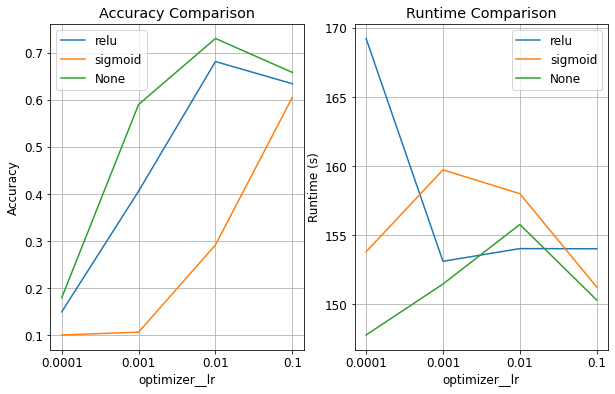

In [38]:
test_score_mlp = mlp_model.cv_results_["mean_test_score"].reshape(len(mlp_parameter_grid["activation_function"]), -1)
n_splits  = mlp_model.n_splits_ # number of splits of training data
n_iter = pd.DataFrame(mlp_model.cv_results_).shape[0] # Iterations per split
mean_fit_time = mlp_model.cv_results_['mean_fit_time'] * n_splits * n_iter
mean_fit_time = mean_fit_time.reshape(len(mlp_parameter_grid["activation_function"]), -1)

print("The best parameter is: ")
print(mlp_param)

MIDDLE_SIZE = 12
plt.rc('font', size=MIDDLE_SIZE)
figure, axis = plt.subplots(1, 2, figsize = (10,6))

# Plot the gragh based on the parameter.
# The first plot is Accuracy.
# The second plot is Runtime comparison
for i in range(len(mlp_parameter_grid["activation_function"])):
    #plt.imshow(X_train[i], cmap="binary")
    axis[0].plot(range(len(mlp_parameter_grid["optimizer__lr"])), test_score_mlp[i], label=str(mlp_parameter_grid["activation_function"][i]))
    axis[1].plot(range(len(mlp_parameter_grid["optimizer__lr"])), mean_fit_time[i], label=str(mlp_parameter_grid["activation_function"][i]))

axis[0].set_xlabel("optimizer__lr")
axis[0].set_ylabel("Accuracy")
axis[0].set_xticks(range(len(mlp_parameter_grid["optimizer__lr"])), mlp_parameter_grid["optimizer__lr"])
axis[0].set_title("Accuracy Comparison")
axis[0].grid(True)
axis[0].legend(loc='best')

axis[1].set_xlabel("optimizer__lr")
axis[1].set_ylabel("Runtime (s)")
axis[1].set_xticks(range(len(mlp_parameter_grid["optimizer__lr"])), mlp_parameter_grid["optimizer__lr"])
axis[1].set_title("Runtime Comparison")
axis[1].set_autoscale_on(True)
axis[1].grid(True)
axis[1].legend(loc='best')

plt.show()

### Convolutional neural network (CNN)

We are looking for the best parameter for CNN. Moreover, we plot the graph to demonstrate the accuracy between different parameter.  
Hyperparameter: kernel size, strides and leraning rate.

In [39]:
cnn_parameter_grid = {
    "kernel_size": [(2, 2),(3, 3)],
    "strides":[(1, 1), (2, 2)],
    "optimizer__lr": [0.0001, 0.001, 0.01, 0.1]
}
cnn_model = tune_cnn(cnn_parameter_grid, x_data=X_train_valid_sub, y_data=y_train_valid_sub)
cnn_param = cnn_model.best_params_

Funtion name: CNN
Epoch 1/20
8/8 [==============================] - 10s 413ms/step - loss: 2.2958 - accuracy: 0.1467 - val_loss: 2.2611 - val_accuracy: 0.2618
Epoch 2/20
8/8 [==============================] - 2s 313ms/step - loss: 2.1780 - accuracy: 0.2511 - val_loss: 1.7973 - val_accuracy: 0.3692
Epoch 3/20
8/8 [==============================] - 2s 171ms/step - loss: 1.6709 - accuracy: 0.3333 - val_loss: 1.6613 - val_accuracy: 0.3632
Epoch 4/20
8/8 [==============================] - 1s 160ms/step - loss: 1.6326 - accuracy: 0.3633 - val_loss: 1.5806 - val_accuracy: 0.3050
Epoch 5/20
8/8 [==============================] - 1s 187ms/step - loss: 1.5695 - accuracy: 0.3300 - val_loss: 1.4172 - val_accuracy: 0.4088
Epoch 6/20
8/8 [==============================] - 1s 183ms/step - loss: 1.4727 - accuracy: 0.3789 - val_loss: 1.3593 - val_accuracy: 0.4077
Epoch 7/20
8/8 [==============================] - 2s 213ms/step - loss: 1.3986 - accuracy: 0.4178 - val_loss: 1.3249 - val_accuracy: 0.4228
E

8/8 [==============================] - 1s 167ms/step - loss: 0.8473 - accuracy: 0.6633 - val_loss: 0.7768 - val_accuracy: 0.6985
Epoch 19/20
8/8 [==============================] - 1s 165ms/step - loss: 0.8048 - accuracy: 0.6867 - val_loss: 0.7639 - val_accuracy: 0.7142
Epoch 20/20
4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 185ms/step - loss: 2.2941 - accuracy: 0.1433 - val_loss: 2.2437 - val_accuracy: 0.3127
Epoch 2/20
8/8 [==============================] - 1s 153ms/step - loss: 2.1166 - accuracy: 0.2878 - val_loss: 1.6763 - val_accuracy: 0.3362
Epoch 3/20
8/8 [==============================] - 1s 153ms/step - loss: 1.6542 - accuracy: 0.3356 - val_loss: 1.5452 - val_accuracy: 0.3525
Epoch 4/20
8/8 [==============================] - 1s 167ms/step - loss: 1.6233 - accuracy: 0.3278 - val_loss: 1.5859 - val_accuracy: 0.3818
Epoch 5/20
8/8 [==============================] - 1s 157ms/step - loss: 1.5709 - accuracy: 0.3289 - val_los

8/8 [==============================] - 2s 214ms/step - loss: 1.1394 - accuracy: 0.5433 - val_loss: 1.0231 - val_accuracy: 0.5865
Epoch 16/20
8/8 [==============================] - 1s 174ms/step - loss: 1.0483 - accuracy: 0.5867 - val_loss: 0.9365 - val_accuracy: 0.6438
Epoch 17/20
8/8 [==============================] - 1s 156ms/step - loss: 0.9401 - accuracy: 0.6122 - val_loss: 0.8735 - val_accuracy: 0.6582
Epoch 18/20
8/8 [==============================] - 1s 191ms/step - loss: 0.8806 - accuracy: 0.6444 - val_loss: 0.8121 - val_accuracy: 0.6810
Epoch 19/20
8/8 [==============================] - 2s 220ms/step - loss: 0.8171 - accuracy: 0.6711 - val_loss: 0.8287 - val_accuracy: 0.6787
Epoch 20/20
4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 216ms/step - loss: 2.2932 - accuracy: 0.1678 - val_loss: 2.2384 - val_accuracy: 0.3088
Epoch 2/20
8/8 [==============================] - 1s 184ms/step - loss: 2.0976 - accuracy: 0.2822 - val_

8/8 [==============================] - 1s 162ms/step - loss: 1.0643 - accuracy: 0.5689 - val_loss: 0.9826 - val_accuracy: 0.6278
Epoch 13/20
8/8 [==============================] - 1s 157ms/step - loss: 1.1335 - accuracy: 0.5656 - val_loss: 0.9939 - val_accuracy: 0.6283
Epoch 14/20
8/8 [==============================] - 1s 157ms/step - loss: 0.9862 - accuracy: 0.6156 - val_loss: 0.9015 - val_accuracy: 0.6592
Epoch 15/20
8/8 [==============================] - 1s 183ms/step - loss: 0.9512 - accuracy: 0.6211 - val_loss: 0.8167 - val_accuracy: 0.6898
Epoch 16/20
8/8 [==============================] - 1s 174ms/step - loss: 0.8215 - accuracy: 0.6744 - val_loss: 0.7748 - val_accuracy: 0.6892
Epoch 17/20
8/8 [==============================] - 2s 205ms/step - loss: 0.7603 - accuracy: 0.6922 - val_loss: 0.8065 - val_accuracy: 0.7020
Epoch 18/20
8/8 [==============================] - 1s 180ms/step - loss: 0.7128 - accuracy: 0.7078 - val_loss: 0.7812 - val_accuracy: 0.6930
Epoch 19/20
8/8 [========

8/8 [==============================] - 1s 112ms/step - loss: 1.4853 - accuracy: 0.3778 - val_loss: 1.4070 - val_accuracy: 0.4315
Epoch 10/20
8/8 [==============================] - 1s 92ms/step - loss: 1.4502 - accuracy: 0.3733 - val_loss: 1.3633 - val_accuracy: 0.4590
Epoch 11/20
8/8 [==============================] - 1s 92ms/step - loss: 1.4185 - accuracy: 0.3967 - val_loss: 1.3619 - val_accuracy: 0.4428
Epoch 12/20
8/8 [==============================] - 1s 93ms/step - loss: 1.4332 - accuracy: 0.3800 - val_loss: 1.3766 - val_accuracy: 0.4072
Epoch 13/20
8/8 [==============================] - 1s 101ms/step - loss: 1.4426 - accuracy: 0.3733 - val_loss: 1.3622 - val_accuracy: 0.4493
Epoch 14/20
8/8 [==============================] - 1s 92ms/step - loss: 1.4369 - accuracy: 0.3900 - val_loss: 1.3572 - val_accuracy: 0.4352
Epoch 15/20
8/8 [==============================] - 1s 92ms/step - loss: 1.3796 - accuracy: 0.4344 - val_loss: 1.3244 - val_accuracy: 0.4045
Epoch 16/20
8/8 [=============

8/8 [==============================] - 1s 104ms/step - loss: 1.5694 - accuracy: 0.3544 - val_loss: 1.4451 - val_accuracy: 0.4153
Epoch 7/20
8/8 [==============================] - 1s 95ms/step - loss: 1.5511 - accuracy: 0.3622 - val_loss: 1.4764 - val_accuracy: 0.3715
Epoch 8/20
8/8 [==============================] - 1s 121ms/step - loss: 1.5560 - accuracy: 0.3589 - val_loss: 1.4168 - val_accuracy: 0.3973
Epoch 9/20
8/8 [==============================] - 1s 94ms/step - loss: 1.5042 - accuracy: 0.3544 - val_loss: 1.4995 - val_accuracy: 0.3808
Epoch 10/20
8/8 [==============================] - 1s 94ms/step - loss: 1.5575 - accuracy: 0.3800 - val_loss: 1.5862 - val_accuracy: 0.3167
Epoch 11/20
8/8 [==============================] - 1s 96ms/step - loss: 1.4999 - accuracy: 0.3800 - val_loss: 1.3956 - val_accuracy: 0.4158
Epoch 12/20
8/8 [==============================] - 1s 118ms/step - loss: 1.4748 - accuracy: 0.4000 - val_loss: 1.3928 - val_accuracy: 0.4187
Epoch 13/20
8/8 [===============

8/8 [==============================] - 1s 113ms/step - loss: 2.2045 - accuracy: 0.2178 - val_loss: 2.0180 - val_accuracy: 0.1785
Epoch 4/20
8/8 [==============================] - 1s 103ms/step - loss: 1.8423 - accuracy: 0.2722 - val_loss: 1.5175 - val_accuracy: 0.3613
Epoch 5/20
8/8 [==============================] - 1s 107ms/step - loss: 1.5953 - accuracy: 0.3333 - val_loss: 1.6789 - val_accuracy: 0.3540
Epoch 6/20
8/8 [==============================] - 1s 94ms/step - loss: 1.6547 - accuracy: 0.3344 - val_loss: 1.5653 - val_accuracy: 0.3182
Epoch 7/20
8/8 [==============================] - 1s 98ms/step - loss: 1.6009 - accuracy: 0.3378 - val_loss: 1.5453 - val_accuracy: 0.4122
Epoch 8/20
8/8 [==============================] - 1s 110ms/step - loss: 1.5370 - accuracy: 0.3844 - val_loss: 1.5025 - val_accuracy: 0.4085
Epoch 9/20
8/8 [==============================] - 1s 95ms/step - loss: 1.5183 - accuracy: 0.3822 - val_loss: 1.4182 - val_accuracy: 0.4092
Epoch 10/20
8/8 [=================

4/4 [==============================] - 0s 2ms/step
Epoch 1/20
8/8 [==============================] - 2s 204ms/step - loss: 2.2955 - accuracy: 0.1456 - val_loss: 2.2651 - val_accuracy: 0.2053
Epoch 2/20
8/8 [==============================] - 1s 164ms/step - loss: 1.8455 - accuracy: 0.3022 - val_loss: 1.5699 - val_accuracy: 0.3448
Epoch 3/20
8/8 [==============================] - 1s 156ms/step - loss: 1.5903 - accuracy: 0.3533 - val_loss: 1.5211 - val_accuracy: 0.3122
Epoch 4/20
8/8 [==============================] - 1s 156ms/step - loss: 1.6466 - accuracy: 0.3244 - val_loss: 1.5440 - val_accuracy: 0.3230
Epoch 5/20
8/8 [==============================] - 1s 156ms/step - loss: 1.4928 - accuracy: 0.3611 - val_loss: 1.3575 - val_accuracy: 0.4130
Epoch 6/20
8/8 [==============================] - 1s 156ms/step - loss: 1.3832 - accuracy: 0.4289 - val_loss: 1.2481 - val_accuracy: 0.4983
Epoch 7/20
8/8 [==============================] - 1s 156ms/step - loss: 1.2627 - accuracy: 0.4856 - val_loss:

8/8 [==============================] - 1s 189ms/step - loss: 0.5464 - accuracy: 0.7656 - val_loss: 0.7279 - val_accuracy: 0.7227
Epoch 19/20
8/8 [==============================] - 2s 206ms/step - loss: 0.5565 - accuracy: 0.7678 - val_loss: 0.6734 - val_accuracy: 0.7345
Epoch 20/20
4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 204ms/step - loss: 2.2487 - accuracy: 0.1389 - val_loss: 1.8678 - val_accuracy: 0.2183
Epoch 2/20
8/8 [==============================] - 1s 195ms/step - loss: 1.7107 - accuracy: 0.2944 - val_loss: 1.9680 - val_accuracy: 0.2550
Epoch 3/20
8/8 [==============================] - 1s 173ms/step - loss: 1.6497 - accuracy: 0.3200 - val_loss: 1.6587 - val_accuracy: 0.3327
Epoch 4/20
8/8 [==============================] - 1s 176ms/step - loss: 1.5658 - accuracy: 0.3500 - val_loss: 1.6678 - val_accuracy: 0.3997
Epoch 5/20
8/8 [==============================] - 1s 173ms/step - loss: 1.5606 - accuracy: 0.4167 - val_los

8/8 [==============================] - 1s 174ms/step - loss: 0.7057 - accuracy: 0.7133 - val_loss: 0.8152 - val_accuracy: 0.6983
Epoch 16/20
8/8 [==============================] - 1s 175ms/step - loss: 0.6526 - accuracy: 0.7267 - val_loss: 0.6738 - val_accuracy: 0.7227
Epoch 17/20
8/8 [==============================] - 1s 179ms/step - loss: 0.5874 - accuracy: 0.7422 - val_loss: 0.7753 - val_accuracy: 0.7170
Epoch 18/20
8/8 [==============================] - 1s 165ms/step - loss: 0.7734 - accuracy: 0.7122 - val_loss: 0.8798 - val_accuracy: 0.6538
Epoch 19/20
8/8 [==============================] - 1s 179ms/step - loss: 0.7237 - accuracy: 0.6956 - val_loss: 0.8169 - val_accuracy: 0.6800
Epoch 20/20
4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 198ms/step - loss: 2.3354 - accuracy: 0.0978 - val_loss: 2.3029 - val_accuracy: 0.0917
Epoch 2/20
8/8 [==============================] - 1s 154ms/step - loss: 2.2871 - accuracy: 0.0989 - val_

8/8 [==============================] - 1s 181ms/step - loss: 0.8161 - accuracy: 0.6700 - val_loss: 0.9125 - val_accuracy: 0.6643
Epoch 13/20
8/8 [==============================] - 1s 189ms/step - loss: 0.7661 - accuracy: 0.7100 - val_loss: 0.7555 - val_accuracy: 0.7395
Epoch 14/20
8/8 [==============================] - 1s 168ms/step - loss: 0.7438 - accuracy: 0.7089 - val_loss: 0.8719 - val_accuracy: 0.6542
Epoch 15/20
8/8 [==============================] - 1s 174ms/step - loss: 0.8481 - accuracy: 0.6500 - val_loss: 0.7493 - val_accuracy: 0.7292
Epoch 16/20
8/8 [==============================] - 1s 155ms/step - loss: 0.6488 - accuracy: 0.7244 - val_loss: 0.8014 - val_accuracy: 0.7260
Epoch 17/20
8/8 [==============================] - 1s 154ms/step - loss: 0.6474 - accuracy: 0.7456 - val_loss: 0.7513 - val_accuracy: 0.6930
Epoch 18/20
8/8 [==============================] - 1s 180ms/step - loss: 0.8770 - accuracy: 0.6611 - val_loss: 0.8583 - val_accuracy: 0.6822
Epoch 19/20
8/8 [========

8/8 [==============================] - 1s 113ms/step - loss: 1.3297 - accuracy: 0.4700 - val_loss: 2.0018 - val_accuracy: 0.2908
Epoch 10/20
8/8 [==============================] - 1s 93ms/step - loss: 1.5896 - accuracy: 0.3856 - val_loss: 1.5066 - val_accuracy: 0.3613
Epoch 11/20
8/8 [==============================] - 1s 134ms/step - loss: 1.3697 - accuracy: 0.4711 - val_loss: 1.2814 - val_accuracy: 0.4683
Epoch 12/20
8/8 [==============================] - 1s 110ms/step - loss: 1.2926 - accuracy: 0.4656 - val_loss: 1.1314 - val_accuracy: 0.5575
Epoch 13/20
8/8 [==============================] - 1s 123ms/step - loss: 1.0457 - accuracy: 0.6156 - val_loss: 0.9205 - val_accuracy: 0.6538
Epoch 14/20
8/8 [==============================] - 1s 93ms/step - loss: 0.9125 - accuracy: 0.6278 - val_loss: 1.0031 - val_accuracy: 0.6417
Epoch 15/20
8/8 [==============================] - 1s 140ms/step - loss: 1.0428 - accuracy: 0.5889 - val_loss: 1.3212 - val_accuracy: 0.5685
Epoch 16/20
8/8 [==========

8/8 [==============================] - 1s 115ms/step - loss: 1.5903 - accuracy: 0.3800 - val_loss: 1.4858 - val_accuracy: 0.3818
Epoch 7/20
8/8 [==============================] - 1s 145ms/step - loss: 1.5061 - accuracy: 0.3978 - val_loss: 1.4917 - val_accuracy: 0.4028
Epoch 8/20
8/8 [==============================] - 1s 128ms/step - loss: 1.4386 - accuracy: 0.3933 - val_loss: 1.4870 - val_accuracy: 0.4053
Epoch 9/20
8/8 [==============================] - 1s 115ms/step - loss: 1.4363 - accuracy: 0.3889 - val_loss: 1.3494 - val_accuracy: 0.4450
Epoch 10/20
8/8 [==============================] - 1s 110ms/step - loss: 1.2937 - accuracy: 0.4778 - val_loss: 1.3354 - val_accuracy: 0.4897
Epoch 11/20
8/8 [==============================] - 1s 102ms/step - loss: 1.1815 - accuracy: 0.5378 - val_loss: 1.1482 - val_accuracy: 0.5632
Epoch 12/20
8/8 [==============================] - 1s 140ms/step - loss: 1.2984 - accuracy: 0.5000 - val_loss: 1.4426 - val_accuracy: 0.4157
Epoch 13/20
8/8 [===========

8/8 [==============================] - 1s 93ms/step - loss: 2.0600 - accuracy: 0.2411 - val_loss: 1.8880 - val_accuracy: 0.2397
Epoch 4/20
8/8 [==============================] - 1s 124ms/step - loss: 1.7499 - accuracy: 0.2733 - val_loss: 1.6198 - val_accuracy: 0.3010
Epoch 5/20
8/8 [==============================] - 1s 114ms/step - loss: 1.6341 - accuracy: 0.3167 - val_loss: 1.6888 - val_accuracy: 0.3010
Epoch 6/20
8/8 [==============================] - 1s 105ms/step - loss: 1.6895 - accuracy: 0.2956 - val_loss: 1.5174 - val_accuracy: 0.3535
Epoch 7/20
8/8 [==============================] - 1s 131ms/step - loss: 1.5446 - accuracy: 0.3089 - val_loss: 1.4679 - val_accuracy: 0.4148
Epoch 8/20
8/8 [==============================] - 1s 106ms/step - loss: 1.4920 - accuracy: 0.3667 - val_loss: 1.4253 - val_accuracy: 0.4047
Epoch 9/20
8/8 [==============================] - 1s 104ms/step - loss: 1.4838 - accuracy: 0.3400 - val_loss: 1.3939 - val_accuracy: 0.4318
Epoch 10/20
8/8 [===============

4/4 [==============================] - 0s 2ms/step
Epoch 1/20
8/8 [==============================] - 2s 196ms/step - loss: 1374.7169 - accuracy: 0.0856 - val_loss: 3.3595 - val_accuracy: 0.1020
Epoch 2/20
8/8 [==============================] - 1s 171ms/step - loss: 2.5636 - accuracy: 0.1000 - val_loss: 2.3054 - val_accuracy: 0.1045
Epoch 3/20
8/8 [==============================] - 1s 170ms/step - loss: 2.3200 - accuracy: 0.1033 - val_loss: 2.3242 - val_accuracy: 0.0995
Epoch 4/20
8/8 [==============================] - 1s 155ms/step - loss: 2.3183 - accuracy: 0.1044 - val_loss: 2.3066 - val_accuracy: 0.1018
Epoch 5/20
8/8 [==============================] - 1s 162ms/step - loss: 2.3432 - accuracy: 0.1078 - val_loss: 2.3034 - val_accuracy: 0.0983
Epoch 6/20
8/8 [==============================] - 1s 154ms/step - loss: 2.6430 - accuracy: 0.1122 - val_loss: 2.3185 - val_accuracy: 0.1045
Epoch 7/20
8/8 [==============================] - 1s 166ms/step - loss: 2.3165 - accuracy: 0.0956 - val_lo

8/8 [==============================] - 1s 174ms/step - loss: 2.3045 - accuracy: 0.1100 - val_loss: 2.3031 - val_accuracy: 0.1018
Epoch 19/20
8/8 [==============================] - 1s 181ms/step - loss: 3.2278 - accuracy: 0.0978 - val_loss: 2.3052 - val_accuracy: 0.1045
Epoch 20/20
4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 181ms/step - loss: 1830.6797 - accuracy: 0.1044 - val_loss: 16.3222 - val_accuracy: 0.0978
Epoch 2/20
8/8 [==============================] - 1s 191ms/step - loss: 4.0495 - accuracy: 0.0800 - val_loss: 2.6096 - val_accuracy: 0.1035
Epoch 3/20
8/8 [==============================] - 1s 182ms/step - loss: 2.4075 - accuracy: 0.1156 - val_loss: 2.3201 - val_accuracy: 0.0995
Epoch 4/20
8/8 [==============================] - 1s 172ms/step - loss: 2.3247 - accuracy: 0.1111 - val_loss: 2.3039 - val_accuracy: 0.1035
Epoch 5/20
8/8 [==============================] - 1s 174ms/step - loss: 2.3084 - accuracy: 0.1056 - val

8/8 [==============================] - 1s 189ms/step - loss: 2.3739 - accuracy: 0.0933 - val_loss: 2.3116 - val_accuracy: 0.1032
Epoch 16/20
8/8 [==============================] - 1s 180ms/step - loss: 2.3401 - accuracy: 0.0867 - val_loss: 2.3081 - val_accuracy: 0.0995
Epoch 17/20
8/8 [==============================] - 1s 159ms/step - loss: 2.3204 - accuracy: 0.0933 - val_loss: 2.3047 - val_accuracy: 0.1018
Epoch 18/20
8/8 [==============================] - 2s 205ms/step - loss: 2.3061 - accuracy: 0.1078 - val_loss: 2.3041 - val_accuracy: 0.1018
Epoch 19/20
8/8 [==============================] - 2s 183ms/step - loss: 2.3024 - accuracy: 0.1156 - val_loss: 2.3043 - val_accuracy: 0.1018
Epoch 20/20
4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 183ms/step - loss: 228.0263 - accuracy: 0.0878 - val_loss: 2.3713 - val_accuracy: 0.0978
Epoch 2/20
8/8 [==============================] - 1s 165ms/step - loss: 2.3297 - accuracy: 0.0822 - va

8/8 [==============================] - 1s 161ms/step - loss: 2.3036 - accuracy: 0.1111 - val_loss: 2.3066 - val_accuracy: 0.0995
Epoch 13/20
8/8 [==============================] - 1s 187ms/step - loss: 2.3056 - accuracy: 0.1000 - val_loss: 2.3051 - val_accuracy: 0.0995
Epoch 14/20
8/8 [==============================] - 2s 220ms/step - loss: 2.3817 - accuracy: 0.1044 - val_loss: 2.6387 - val_accuracy: 0.1045
Epoch 15/20
8/8 [==============================] - 1s 185ms/step - loss: 2.3603 - accuracy: 0.1056 - val_loss: 2.3103 - val_accuracy: 0.1035
Epoch 16/20
8/8 [==============================] - 1s 184ms/step - loss: 2.3336 - accuracy: 0.0944 - val_loss: 2.3120 - val_accuracy: 0.1018
Epoch 17/20
8/8 [==============================] - 1s 184ms/step - loss: 2.3262 - accuracy: 0.1067 - val_loss: 2.3071 - val_accuracy: 0.1035
Epoch 18/20
8/8 [==============================] - 1s 171ms/step - loss: 2.3071 - accuracy: 0.1211 - val_loss: 2.3057 - val_accuracy: 0.1032
Epoch 19/20
8/8 [========

8/8 [==============================] - 1s 98ms/step - loss: 2.3079 - accuracy: 0.1044 - val_loss: 2.3093 - val_accuracy: 0.0983
Epoch 10/20
8/8 [==============================] - 1s 118ms/step - loss: 2.3031 - accuracy: 0.1122 - val_loss: 2.3087 - val_accuracy: 0.0983
Epoch 11/20
8/8 [==============================] - 1s 97ms/step - loss: 2.3052 - accuracy: 0.1011 - val_loss: 2.3072 - val_accuracy: 0.1018
Epoch 12/20
8/8 [==============================] - 1s 115ms/step - loss: 2.3011 - accuracy: 0.1078 - val_loss: 2.3081 - val_accuracy: 0.1018
Epoch 13/20
8/8 [==============================] - 1s 103ms/step - loss: 2.3072 - accuracy: 0.1033 - val_loss: 2.3079 - val_accuracy: 0.1018
Epoch 14/20
8/8 [==============================] - 1s 139ms/step - loss: 2.3080 - accuracy: 0.0789 - val_loss: 2.3065 - val_accuracy: 0.0983
Epoch 15/20
8/8 [==============================] - 1s 134ms/step - loss: 2.3080 - accuracy: 0.0989 - val_loss: 2.3065 - val_accuracy: 0.0983
Epoch 16/20
8/8 [==========

8/8 [==============================] - 1s 106ms/step - loss: 2.3126 - accuracy: 0.0978 - val_loss: 2.3076 - val_accuracy: 0.0917
Epoch 7/20
8/8 [==============================] - 1s 122ms/step - loss: 2.3088 - accuracy: 0.1033 - val_loss: 2.3104 - val_accuracy: 0.1018
Epoch 8/20
8/8 [==============================] - 1s 93ms/step - loss: 2.3063 - accuracy: 0.1189 - val_loss: 2.3105 - val_accuracy: 0.1018
Epoch 9/20
8/8 [==============================] - 1s 142ms/step - loss: 2.3108 - accuracy: 0.0933 - val_loss: 2.3114 - val_accuracy: 0.0983
Epoch 10/20
8/8 [==============================] - 1s 143ms/step - loss: 2.3089 - accuracy: 0.0978 - val_loss: 2.3126 - val_accuracy: 0.0983
Epoch 11/20
8/8 [==============================] - 1s 110ms/step - loss: 2.3053 - accuracy: 0.1100 - val_loss: 2.3085 - val_accuracy: 0.0978
Epoch 12/20
8/8 [==============================] - 1s 129ms/step - loss: 2.3032 - accuracy: 0.1011 - val_loss: 2.3057 - val_accuracy: 0.0983
Epoch 13/20
8/8 [============

8/8 [==============================] - 1s 119ms/step - loss: 2.3129 - accuracy: 0.1011 - val_loss: 2.3096 - val_accuracy: 0.1182
Epoch 4/20
8/8 [==============================] - 1s 155ms/step - loss: 2.3297 - accuracy: 0.0911 - val_loss: 2.3079 - val_accuracy: 0.0983
Epoch 5/20
8/8 [==============================] - 1s 98ms/step - loss: 2.3148 - accuracy: 0.1056 - val_loss: 2.3148 - val_accuracy: 0.1355
Epoch 6/20
8/8 [==============================] - 1s 127ms/step - loss: 2.6229 - accuracy: 0.1011 - val_loss: 2.3350 - val_accuracy: 0.1032
Epoch 7/20
8/8 [==============================] - 1s 131ms/step - loss: 2.3270 - accuracy: 0.1144 - val_loss: 2.3084 - val_accuracy: 0.1018
Epoch 8/20
8/8 [==============================] - 1s 108ms/step - loss: 2.3037 - accuracy: 0.0978 - val_loss: 2.3070 - val_accuracy: 0.0995
Epoch 9/20
8/8 [==============================] - 1s 110ms/step - loss: 2.3091 - accuracy: 0.0978 - val_loss: 2.3057 - val_accuracy: 0.0983
Epoch 10/20
8/8 [===============

4/4 [==============================] - 0s 2ms/step
Epoch 1/20
8/8 [==============================] - 2s 227ms/step - loss: 24274052055040.0000 - accuracy: 0.1022 - val_loss: 1472484992.0000 - val_accuracy: 0.0995
Epoch 2/20
8/8 [==============================] - 1s 178ms/step - loss: 531351552.0000 - accuracy: 0.1000 - val_loss: 208648048.0000 - val_accuracy: 0.1045
Epoch 3/20
8/8 [==============================] - 1s 171ms/step - loss: 546152192.0000 - accuracy: 0.1000 - val_loss: 12527660.0000 - val_accuracy: 0.0995
Epoch 4/20
8/8 [==============================] - 1s 178ms/step - loss: 8396539.0000 - accuracy: 0.0978 - val_loss: 2295743.2500 - val_accuracy: 0.0917
Epoch 5/20
8/8 [==============================] - 2s 223ms/step - loss: 1009963.0000 - accuracy: 0.1111 - val_loss: 2.4310 - val_accuracy: 0.1035
Epoch 6/20
8/8 [==============================] - 2s 209ms/step - loss: 11504.1748 - accuracy: 0.1000 - val_loss: 2.4109 - val_accuracy: 0.1035
Epoch 7/20
8/8 [==================

8/8 [==============================] - 2s 236ms/step - loss: 6.4955 - accuracy: 0.1067 - val_loss: 2.3072 - val_accuracy: 0.0995
Epoch 16/20
8/8 [==============================] - 2s 218ms/step - loss: 2.3052 - accuracy: 0.1078 - val_loss: 2.3043 - val_accuracy: 0.0995
Epoch 17/20
8/8 [==============================] - 1s 187ms/step - loss: 2.3281 - accuracy: 0.1033 - val_loss: 2.3054 - val_accuracy: 0.1013
Epoch 18/20
8/8 [==============================] - 2s 215ms/step - loss: 84.4579 - accuracy: 0.0933 - val_loss: 2.3058 - val_accuracy: 0.0983
Epoch 19/20
8/8 [==============================] - 2s 222ms/step - loss: 6.6608 - accuracy: 0.0978 - val_loss: 2.3051 - val_accuracy: 0.0983
Epoch 20/20
4/4 [==============================] - 0s 5ms/step
Epoch 1/20
8/8 [==============================] - 3s 239ms/step - loss: 14670136082432.0000 - accuracy: 0.0789 - val_loss: 28560074752.0000 - val_accuracy: 0.1035
Epoch 2/20
8/8 [==============================] - 1s 151ms/step - loss: 18878811

8/8 [==============================] - 1s 183ms/step - loss: 19.2349 - accuracy: 0.1111 - val_loss: 2.3316 - val_accuracy: 0.1018
Epoch 11/20
8/8 [==============================] - 1s 193ms/step - loss: 100.7832 - accuracy: 0.1111 - val_loss: 2.3170 - val_accuracy: 0.1018
Epoch 12/20
8/8 [==============================] - 1s 161ms/step - loss: 2.3130 - accuracy: 0.1000 - val_loss: 2.3111 - val_accuracy: 0.0995
Epoch 13/20
8/8 [==============================] - 2s 206ms/step - loss: 51.2313 - accuracy: 0.1067 - val_loss: 2.3086 - val_accuracy: 0.0995
Epoch 14/20
8/8 [==============================] - 1s 167ms/step - loss: 2.3041 - accuracy: 0.1078 - val_loss: 2.3083 - val_accuracy: 0.0995
Epoch 15/20
8/8 [==============================] - 1s 183ms/step - loss: 2.3027 - accuracy: 0.1100 - val_loss: 2.3085 - val_accuracy: 0.1018
Epoch 16/20
8/8 [==============================] - 1s 168ms/step - loss: 2.3040 - accuracy: 0.1111 - val_loss: 2.3111 - val_accuracy: 0.1018
Epoch 17/20
8/8 [====

Epoch 5/20
8/8 [==============================] - 1s 185ms/step - loss: 420910848.0000 - accuracy: 0.0944 - val_loss: 268.5218 - val_accuracy: 0.1032
Epoch 6/20
8/8 [==============================] - 1s 158ms/step - loss: 3086681344.0000 - accuracy: 0.0878 - val_loss: 136.5723 - val_accuracy: 0.0978
Epoch 7/20
8/8 [==============================] - 1s 174ms/step - loss: 151.9627 - accuracy: 0.1067 - val_loss: 39.0590 - val_accuracy: 0.1045
Epoch 8/20
8/8 [==============================] - 1s 201ms/step - loss: 86.2716 - accuracy: 0.1144 - val_loss: 13.0943 - val_accuracy: 0.1045
Epoch 9/20
8/8 [==============================] - 1s 156ms/step - loss: 25.5999 - accuracy: 0.0967 - val_loss: 2.9827 - val_accuracy: 0.1035
Epoch 10/20
8/8 [==============================] - 1s 156ms/step - loss: 3.6229 - accuracy: 0.0911 - val_loss: 2.6547 - val_accuracy: 0.1035
Epoch 11/20
8/8 [==============================] - 1s 156ms/step - loss: 2.7275 - accuracy: 0.0956 - val_loss: 2.4567 - val_accuracy

4/4 [==============================] - 0s 3ms/step
Epoch 1/20
8/8 [==============================] - 2s 165ms/step - loss: 21417981952.0000 - accuracy: 0.1022 - val_loss: 3112200704.0000 - val_accuracy: 0.1035
Epoch 2/20
8/8 [==============================] - 1s 130ms/step - loss: 707388224.0000 - accuracy: 0.1122 - val_loss: 19732446.0000 - val_accuracy: 0.0983
Epoch 3/20
8/8 [==============================] - 1s 118ms/step - loss: 4597810.0000 - accuracy: 0.1078 - val_loss: 539833.1875 - val_accuracy: 0.0917
Epoch 4/20
8/8 [==============================] - 1s 105ms/step - loss: 243025.4531 - accuracy: 0.1144 - val_loss: 25840.8184 - val_accuracy: 0.0983
Epoch 5/20
8/8 [==============================] - 1s 127ms/step - loss: 479812.3750 - accuracy: 0.0944 - val_loss: 387684.5938 - val_accuracy: 0.1013
Epoch 6/20
8/8 [==============================] - 1s 134ms/step - loss: 871689.8125 - accuracy: 0.0911 - val_loss: 655002.5625 - val_accuracy: 0.0995
Epoch 7/20
8/8 [===================

8/8 [==============================] - 2s 293ms/step - loss: 2.3076 - accuracy: 0.0956 - val_loss: 2.3144 - val_accuracy: 0.0978
Epoch 17/20
8/8 [==============================] - 3s 338ms/step - loss: 2.3117 - accuracy: 0.1022 - val_loss: 2.3169 - val_accuracy: 0.0978
Epoch 18/20
8/8 [==============================] - 2s 304ms/step - loss: 2.3090 - accuracy: 0.1022 - val_loss: 2.3114 - val_accuracy: 0.0978
Epoch 19/20
8/8 [==============================] - 3s 323ms/step - loss: 2.3071 - accuracy: 0.1022 - val_loss: 2.3093 - val_accuracy: 0.0978
Epoch 20/20
4/4 [==============================] - 0s 2ms/step
Epoch 1/20
8/8 [==============================] - 3s 287ms/step - loss: 72991596544.0000 - accuracy: 0.1089 - val_loss: 87247626240.0000 - val_accuracy: 0.1032
Epoch 2/20
8/8 [==============================] - 2s 263ms/step - loss: 13312515072.0000 - accuracy: 0.1033 - val_loss: 216345200.0000 - val_accuracy: 0.0983
Epoch 3/20
8/8 [==============================] - 1s 176ms/step - l

Epoch 11/20
8/8 [==============================] - 2s 271ms/step - loss: 130346728.0000 - accuracy: 0.0978 - val_loss: 2.3149 - val_accuracy: 0.1018
Epoch 12/20
8/8 [==============================] - 2s 312ms/step - loss: 8295821312.0000 - accuracy: 0.1144 - val_loss: 2.3175 - val_accuracy: 0.1018
Epoch 13/20
8/8 [==============================] - 2s 298ms/step - loss: 8321646.0000 - accuracy: 0.1044 - val_loss: 2.3268 - val_accuracy: 0.1018
Epoch 14/20
8/8 [==============================] - 2s 262ms/step - loss: 479257.8750 - accuracy: 0.0978 - val_loss: 58607148.0000 - val_accuracy: 0.1018
Epoch 15/20
8/8 [==============================] - 1s 122ms/step - loss: 9030393.0000 - accuracy: 0.1067 - val_loss: 2245714.0000 - val_accuracy: 0.1013
Epoch 16/20
8/8 [==============================] - 1s 116ms/step - loss: 954968.4375 - accuracy: 0.1067 - val_loss: 2.3138 - val_accuracy: 0.0978
Epoch 17/20
8/8 [==============================] - 1s 103ms/step - loss: 237076.5469 - accuracy: 0.103

8/8 [==============================] - 3s 359ms/step - loss: 14061.9902 - accuracy: 0.0844 - val_loss: 2.4335 - val_accuracy: 0.0917
Epoch 7/20
8/8 [==============================] - 3s 350ms/step - loss: 6124.6655 - accuracy: 0.1000 - val_loss: 2.3948 - val_accuracy: 0.0995
Epoch 8/20
8/8 [==============================] - 2s 289ms/step - loss: 56658.7148 - accuracy: 0.1078 - val_loss: 2.3534 - val_accuracy: 0.0995
Epoch 9/20
8/8 [==============================] - 2s 278ms/step - loss: 10151.8115 - accuracy: 0.1033 - val_loss: 2.3303 - val_accuracy: 0.0995
Epoch 10/20
8/8 [==============================] - 2s 210ms/step - loss: 44653284.0000 - accuracy: 0.1044 - val_loss: 2377723.7500 - val_accuracy: 0.1045
Epoch 11/20
8/8 [==============================] - 1s 91ms/step - loss: 596267.1875 - accuracy: 0.1011 - val_loss: 2.3244 - val_accuracy: 0.0978
Epoch 12/20
8/8 [==============================] - 1s 115ms/step - loss: 3508913.2500 - accuracy: 0.0978 - val_loss: 2.3219 - val_accurac

Epoch 3/20
8/8 [==============================] - 1s 116ms/step - loss: 1.7159 - accuracy: 0.3333 - val_loss: 1.6989 - val_accuracy: 0.3680
Epoch 4/20
8/8 [==============================] - 1s 118ms/step - loss: 1.6820 - accuracy: 0.3633 - val_loss: 1.6473 - val_accuracy: 0.3287
Epoch 5/20
8/8 [==============================] - 1s 118ms/step - loss: 1.6673 - accuracy: 0.3633 - val_loss: 1.5064 - val_accuracy: 0.3887
Epoch 6/20
8/8 [==============================] - 1s 118ms/step - loss: 1.5250 - accuracy: 0.3756 - val_loss: 1.2789 - val_accuracy: 0.4958
Epoch 7/20
8/8 [==============================] - 1s 118ms/step - loss: 1.3557 - accuracy: 0.4744 - val_loss: 1.2636 - val_accuracy: 0.4722
Epoch 8/20
8/8 [==============================] - 1s 118ms/step - loss: 1.3184 - accuracy: 0.4700 - val_loss: 1.2203 - val_accuracy: 0.4775
Epoch 9/20
8/8 [==============================] - 1s 117ms/step - loss: 1.2340 - accuracy: 0.5189 - val_loss: 1.1276 - val_accuracy: 0.6040
Epoch 10/20
8/8 [===

4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 149ms/step - loss: 2.2961 - accuracy: 0.1567 - val_loss: 2.2599 - val_accuracy: 0.2098
Epoch 2/20
8/8 [==============================] - 1s 118ms/step - loss: 2.1738 - accuracy: 0.2178 - val_loss: 1.7836 - val_accuracy: 0.3375
Epoch 3/20
8/8 [==============================] - 1s 123ms/step - loss: 1.6796 - accuracy: 0.3344 - val_loss: 1.4577 - val_accuracy: 0.4122
Epoch 4/20
8/8 [==============================] - 1s 120ms/step - loss: 1.6210 - accuracy: 0.3800 - val_loss: 1.5811 - val_accuracy: 0.3810
Epoch 5/20
8/8 [==============================] - 1s 120ms/step - loss: 1.5780 - accuracy: 0.3756 - val_loss: 1.4447 - val_accuracy: 0.3900
Epoch 6/20
8/8 [==============================] - 1s 120ms/step - loss: 1.5034 - accuracy: 0.3789 - val_loss: 1.3884 - val_accuracy: 0.4535
Epoch 7/20
8/8 [==============================] - 1s 136ms/step - loss: 1.4610 - accuracy: 0.4067 - val_loss:

8/8 [==============================] - 1s 117ms/step - loss: 0.7011 - accuracy: 0.7078 - val_loss: 0.7721 - val_accuracy: 0.7100
Epoch 18/20
8/8 [==============================] - 1s 117ms/step - loss: 0.7740 - accuracy: 0.6844 - val_loss: 0.7151 - val_accuracy: 0.7300
Epoch 19/20
8/8 [==============================] - 1s 118ms/step - loss: 0.7050 - accuracy: 0.7067 - val_loss: 0.7183 - val_accuracy: 0.7263
Epoch 20/20
4/4 [==============================] - 0s 5ms/step
Epoch 1/20
8/8 [==============================] - 2s 146ms/step - loss: 2.2982 - accuracy: 0.1000 - val_loss: 2.2742 - val_accuracy: 0.2662
Epoch 2/20
8/8 [==============================] - 1s 119ms/step - loss: 2.2243 - accuracy: 0.2156 - val_loss: 1.9816 - val_accuracy: 0.2773
Epoch 3/20
8/8 [==============================] - 1s 119ms/step - loss: 1.7869 - accuracy: 0.3067 - val_loss: 1.5932 - val_accuracy: 0.3792
Epoch 4/20
8/8 [==============================] - 1s 119ms/step - loss: 1.6267 - accuracy: 0.3756 - val_lo

8/8 [==============================] - 0s 65ms/step - loss: 1.2068 - accuracy: 0.4967 - val_loss: 1.0740 - val_accuracy: 0.5758
Epoch 15/20
8/8 [==============================] - 0s 65ms/step - loss: 1.1309 - accuracy: 0.5256 - val_loss: 1.0539 - val_accuracy: 0.5545
Epoch 16/20
8/8 [==============================] - 0s 65ms/step - loss: 1.0460 - accuracy: 0.5700 - val_loss: 1.0530 - val_accuracy: 0.5813
Epoch 17/20
8/8 [==============================] - 0s 63ms/step - loss: 0.9916 - accuracy: 0.6156 - val_loss: 0.9951 - val_accuracy: 0.5705
Epoch 18/20
8/8 [==============================] - 0s 66ms/step - loss: 0.9952 - accuracy: 0.5933 - val_loss: 0.9602 - val_accuracy: 0.6208
Epoch 19/20
8/8 [==============================] - 0s 67ms/step - loss: 0.9578 - accuracy: 0.6322 - val_loss: 0.9274 - val_accuracy: 0.6338
Epoch 20/20
4/4 [==============================] - 0s 3ms/step
Epoch 1/20
8/8 [==============================] - 1s 92ms/step - loss: 2.3018 - accuracy: 0.1044 - val_loss: 

Epoch 12/20
8/8 [==============================] - 1s 74ms/step - loss: 1.4042 - accuracy: 0.4244 - val_loss: 1.3420 - val_accuracy: 0.4625
Epoch 13/20
8/8 [==============================] - 0s 67ms/step - loss: 1.3437 - accuracy: 0.4344 - val_loss: 1.3325 - val_accuracy: 0.4157
Epoch 14/20
8/8 [==============================] - 0s 63ms/step - loss: 1.3770 - accuracy: 0.4200 - val_loss: 1.3172 - val_accuracy: 0.4633
Epoch 15/20
8/8 [==============================] - 0s 67ms/step - loss: 1.3120 - accuracy: 0.4567 - val_loss: 1.2291 - val_accuracy: 0.4897
Epoch 16/20
8/8 [==============================] - 0s 66ms/step - loss: 1.2887 - accuracy: 0.4378 - val_loss: 1.2157 - val_accuracy: 0.4717
Epoch 17/20
8/8 [==============================] - 0s 66ms/step - loss: 1.2408 - accuracy: 0.5056 - val_loss: 1.1346 - val_accuracy: 0.5163
Epoch 18/20
8/8 [==============================] - 0s 66ms/step - loss: 1.1502 - accuracy: 0.5122 - val_loss: 1.1431 - val_accuracy: 0.5133
Epoch 19/20
8/8 [===

8/8 [==============================] - 0s 67ms/step - loss: 1.4965 - accuracy: 0.3611 - val_loss: 1.4070 - val_accuracy: 0.3987
Epoch 10/20
8/8 [==============================] - 0s 64ms/step - loss: 1.4736 - accuracy: 0.3911 - val_loss: 1.4701 - val_accuracy: 0.4018
Epoch 11/20
8/8 [==============================] - 0s 65ms/step - loss: 1.4367 - accuracy: 0.4267 - val_loss: 1.3666 - val_accuracy: 0.4528
Epoch 12/20
8/8 [==============================] - 0s 66ms/step - loss: 1.3838 - accuracy: 0.4500 - val_loss: 1.3274 - val_accuracy: 0.4543
Epoch 13/20
8/8 [==============================] - 0s 63ms/step - loss: 1.4279 - accuracy: 0.4222 - val_loss: 1.3137 - val_accuracy: 0.4597
Epoch 14/20
8/8 [==============================] - 0s 64ms/step - loss: 1.4107 - accuracy: 0.4033 - val_loss: 1.3534 - val_accuracy: 0.4548
Epoch 15/20
8/8 [==============================] - 0s 64ms/step - loss: 1.3876 - accuracy: 0.4356 - val_loss: 1.3384 - val_accuracy: 0.4825
Epoch 16/20
8/8 [===============

Epoch 7/20
8/8 [==============================] - 0s 56ms/step - loss: 1.5620 - accuracy: 0.3844 - val_loss: 1.4921 - val_accuracy: 0.3822
Epoch 8/20
8/8 [==============================] - 0s 62ms/step - loss: 1.5150 - accuracy: 0.4100 - val_loss: 1.3885 - val_accuracy: 0.4138
Epoch 9/20
8/8 [==============================] - 0s 59ms/step - loss: 1.4724 - accuracy: 0.3633 - val_loss: 1.4685 - val_accuracy: 0.3650
Epoch 10/20
8/8 [==============================] - 0s 60ms/step - loss: 1.4767 - accuracy: 0.3856 - val_loss: 1.3893 - val_accuracy: 0.3970
Epoch 11/20
8/8 [==============================] - 0s 56ms/step - loss: 1.4238 - accuracy: 0.4233 - val_loss: 1.3809 - val_accuracy: 0.4328
Epoch 12/20
8/8 [==============================] - 0s 56ms/step - loss: 1.4350 - accuracy: 0.4322 - val_loss: 1.3541 - val_accuracy: 0.4400
Epoch 13/20
8/8 [==============================] - 0s 57ms/step - loss: 1.3604 - accuracy: 0.4400 - val_loss: 1.3246 - val_accuracy: 0.4465
Epoch 14/20
8/8 [======

8/8 [==============================] - 1s 118ms/step - loss: 2.1221 - accuracy: 0.1811 - val_loss: 2.0510 - val_accuracy: 0.2687
Epoch 5/20
8/8 [==============================] - 1s 131ms/step - loss: 1.8223 - accuracy: 0.2956 - val_loss: 2.9641 - val_accuracy: 0.2428
Epoch 6/20
8/8 [==============================] - 1s 122ms/step - loss: 2.0137 - accuracy: 0.2733 - val_loss: 1.9044 - val_accuracy: 0.2320
Epoch 7/20
8/8 [==============================] - 1s 146ms/step - loss: 1.7482 - accuracy: 0.3000 - val_loss: 1.7288 - val_accuracy: 0.3238
Epoch 8/20
8/8 [==============================] - 1s 175ms/step - loss: 1.6262 - accuracy: 0.3300 - val_loss: 1.4183 - val_accuracy: 0.4083
Epoch 9/20
8/8 [==============================] - 1s 162ms/step - loss: 1.4917 - accuracy: 0.3767 - val_loss: 1.5427 - val_accuracy: 0.3547
Epoch 10/20
8/8 [==============================] - 1s 125ms/step - loss: 1.5391 - accuracy: 0.3289 - val_loss: 1.3966 - val_accuracy: 0.4322
Epoch 11/20
8/8 [=============

8/8 [==============================] - 2s 154ms/step - loss: 2.2774 - accuracy: 0.1589 - val_loss: 2.2779 - val_accuracy: 0.2403
Epoch 2/20
8/8 [==============================] - 1s 120ms/step - loss: 1.8909 - accuracy: 0.3089 - val_loss: 1.6090 - val_accuracy: 0.2970
Epoch 3/20
8/8 [==============================] - 1s 121ms/step - loss: 1.5921 - accuracy: 0.3389 - val_loss: 1.6577 - val_accuracy: 0.2850
Epoch 4/20
8/8 [==============================] - 1s 120ms/step - loss: 1.5989 - accuracy: 0.3611 - val_loss: 1.9338 - val_accuracy: 0.3745
Epoch 5/20
8/8 [==============================] - 1s 123ms/step - loss: 1.5761 - accuracy: 0.3656 - val_loss: 1.6204 - val_accuracy: 0.3670
Epoch 6/20
8/8 [==============================] - 1s 119ms/step - loss: 1.4620 - accuracy: 0.4033 - val_loss: 1.6244 - val_accuracy: 0.3872
Epoch 7/20
8/8 [==============================] - 1s 130ms/step - loss: 1.3801 - accuracy: 0.4800 - val_loss: 1.3132 - val_accuracy: 0.4997
Epoch 8/20
8/8 [===============

8/8 [==============================] - 1s 148ms/step - loss: 0.7336 - accuracy: 0.7156 - val_loss: 0.7032 - val_accuracy: 0.7285
Epoch 19/20
8/8 [==============================] - 1s 150ms/step - loss: 0.6373 - accuracy: 0.7156 - val_loss: 0.7526 - val_accuracy: 0.7285
Epoch 20/20
4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 193ms/step - loss: 2.3201 - accuracy: 0.1111 - val_loss: 2.3036 - val_accuracy: 0.0978
Epoch 2/20
8/8 [==============================] - 1s 148ms/step - loss: 2.2788 - accuracy: 0.1233 - val_loss: 2.0078 - val_accuracy: 0.2270
Epoch 3/20
8/8 [==============================] - 1s 146ms/step - loss: 1.8653 - accuracy: 0.2656 - val_loss: 1.6301 - val_accuracy: 0.3235
Epoch 4/20
8/8 [==============================] - 1s 147ms/step - loss: 1.5385 - accuracy: 0.3656 - val_loss: 1.5791 - val_accuracy: 0.3648
Epoch 5/20
8/8 [==============================] - 1s 146ms/step - loss: 1.5966 - accuracy: 0.3433 - val_los

8/8 [==============================] - 0s 56ms/step - loss: 1.0102 - accuracy: 0.6078 - val_loss: 0.9618 - val_accuracy: 0.6515
Epoch 16/20
8/8 [==============================] - 0s 55ms/step - loss: 0.9504 - accuracy: 0.6300 - val_loss: 0.9854 - val_accuracy: 0.6195
Epoch 17/20
8/8 [==============================] - 0s 56ms/step - loss: 0.9992 - accuracy: 0.6011 - val_loss: 0.9139 - val_accuracy: 0.6615
Epoch 18/20
8/8 [==============================] - 0s 56ms/step - loss: 0.8798 - accuracy: 0.6622 - val_loss: 0.8702 - val_accuracy: 0.6493
Epoch 19/20
8/8 [==============================] - 0s 59ms/step - loss: 0.8800 - accuracy: 0.6400 - val_loss: 0.8841 - val_accuracy: 0.6482
Epoch 20/20
4/4 [==============================] - 0s 2ms/step
Epoch 1/20
8/8 [==============================] - 1s 84ms/step - loss: 2.3067 - accuracy: 0.0967 - val_loss: 2.3019 - val_accuracy: 0.0995
Epoch 2/20
8/8 [==============================] - 0s 56ms/step - loss: 2.2591 - accuracy: 0.1178 - val_loss: 2

Epoch 13/20
8/8 [==============================] - 0s 55ms/step - loss: 1.4205 - accuracy: 0.3944 - val_loss: 1.4445 - val_accuracy: 0.4748
Epoch 14/20
8/8 [==============================] - 0s 56ms/step - loss: 1.4190 - accuracy: 0.4378 - val_loss: 1.3181 - val_accuracy: 0.5023
Epoch 15/20
8/8 [==============================] - 0s 55ms/step - loss: 1.2785 - accuracy: 0.4744 - val_loss: 1.1427 - val_accuracy: 0.5035
Epoch 16/20
8/8 [==============================] - 0s 57ms/step - loss: 1.1034 - accuracy: 0.5433 - val_loss: 1.1339 - val_accuracy: 0.5175
Epoch 17/20
8/8 [==============================] - 0s 67ms/step - loss: 1.0746 - accuracy: 0.5511 - val_loss: 0.9990 - val_accuracy: 0.5975
Epoch 18/20
8/8 [==============================] - 0s 66ms/step - loss: 0.9854 - accuracy: 0.5911 - val_loss: 1.1295 - val_accuracy: 0.6265
Epoch 19/20
8/8 [==============================] - 0s 57ms/step - loss: 0.9728 - accuracy: 0.6333 - val_loss: 0.9035 - val_accuracy: 0.6663
Epoch 20/20
4/4 [===

8/8 [==============================] - 0s 57ms/step - loss: 1.6275 - accuracy: 0.3233 - val_loss: 1.4664 - val_accuracy: 0.3750
Epoch 11/20
8/8 [==============================] - 0s 58ms/step - loss: 1.4703 - accuracy: 0.4122 - val_loss: 1.4568 - val_accuracy: 0.4408
Epoch 12/20
8/8 [==============================] - 0s 57ms/step - loss: 1.4710 - accuracy: 0.4078 - val_loss: 1.3324 - val_accuracy: 0.4168
Epoch 13/20
8/8 [==============================] - 0s 55ms/step - loss: 1.3285 - accuracy: 0.4089 - val_loss: 1.3093 - val_accuracy: 0.4398
Epoch 14/20
8/8 [==============================] - 0s 56ms/step - loss: 1.2993 - accuracy: 0.4189 - val_loss: 1.4281 - val_accuracy: 0.4007
Epoch 15/20
8/8 [==============================] - 0s 55ms/step - loss: 1.3811 - accuracy: 0.4200 - val_loss: 1.2596 - val_accuracy: 0.5093
Epoch 16/20
8/8 [==============================] - 0s 56ms/step - loss: 1.2738 - accuracy: 0.4878 - val_loss: 1.2481 - val_accuracy: 0.4810
Epoch 17/20
8/8 [===============

Epoch 8/20
8/8 [==============================] - 0s 67ms/step - loss: 1.4761 - accuracy: 0.4000 - val_loss: 1.4212 - val_accuracy: 0.4593
Epoch 9/20
8/8 [==============================] - 1s 68ms/step - loss: 1.4345 - accuracy: 0.3722 - val_loss: 1.4321 - val_accuracy: 0.3838
Epoch 10/20
8/8 [==============================] - 0s 65ms/step - loss: 1.3946 - accuracy: 0.3844 - val_loss: 1.2903 - val_accuracy: 0.4438
Epoch 11/20
8/8 [==============================] - 0s 67ms/step - loss: 1.2978 - accuracy: 0.4500 - val_loss: 1.2019 - val_accuracy: 0.5165
Epoch 12/20
8/8 [==============================] - 0s 67ms/step - loss: 1.1666 - accuracy: 0.5300 - val_loss: 1.5164 - val_accuracy: 0.4140
Epoch 13/20
8/8 [==============================] - 0s 67ms/step - loss: 1.2688 - accuracy: 0.4767 - val_loss: 1.1726 - val_accuracy: 0.5322
Epoch 14/20
8/8 [==============================] - 1s 70ms/step - loss: 1.1622 - accuracy: 0.5322 - val_loss: 1.0340 - val_accuracy: 0.5893
Epoch 15/20
8/8 [=====

8/8 [==============================] - 1s 167ms/step - loss: 2.3066 - accuracy: 0.0956 - val_loss: 2.3070 - val_accuracy: 0.1045
Epoch 6/20
8/8 [==============================] - 1s 165ms/step - loss: 2.3044 - accuracy: 0.1122 - val_loss: 2.3050 - val_accuracy: 0.1018
Epoch 7/20
8/8 [==============================] - 1s 172ms/step - loss: 2.3033 - accuracy: 0.1067 - val_loss: 2.3072 - val_accuracy: 0.1018
Epoch 8/20
8/8 [==============================] - 1s 163ms/step - loss: 2.3037 - accuracy: 0.1122 - val_loss: 2.3097 - val_accuracy: 0.1018
Epoch 9/20
8/8 [==============================] - 1s 154ms/step - loss: 2.3070 - accuracy: 0.1122 - val_loss: 2.3140 - val_accuracy: 0.1018
Epoch 10/20
8/8 [==============================] - 1s 156ms/step - loss: 4.5711 - accuracy: 0.1078 - val_loss: 3.3078 - val_accuracy: 0.1035
Epoch 11/20
8/8 [==============================] - 1s 156ms/step - loss: 5.4684 - accuracy: 0.0944 - val_loss: 6.6399 - val_accuracy: 0.1045
Epoch 12/20
8/8 [============

8/8 [==============================] - 1s 138ms/step - loss: 15.3598 - accuracy: 0.0978 - val_loss: 3.8028 - val_accuracy: 0.0995
Epoch 3/20
8/8 [==============================] - 1s 119ms/step - loss: 2.9259 - accuracy: 0.1144 - val_loss: 2.3860 - val_accuracy: 0.0995
Epoch 4/20
8/8 [==============================] - 1s 120ms/step - loss: 2.3647 - accuracy: 0.1044 - val_loss: 2.3030 - val_accuracy: 0.1032
Epoch 5/20
8/8 [==============================] - 1s 138ms/step - loss: 2.3086 - accuracy: 0.0933 - val_loss: 2.3045 - val_accuracy: 0.0995
Epoch 6/20
8/8 [==============================] - 1s 132ms/step - loss: 2.3478 - accuracy: 0.1089 - val_loss: 2.3081 - val_accuracy: 0.1032
Epoch 7/20
8/8 [==============================] - 1s 163ms/step - loss: 2.9540 - accuracy: 0.1056 - val_loss: 2.3085 - val_accuracy: 0.0917
Epoch 8/20
8/8 [==============================] - 1s 144ms/step - loss: 3.1178 - accuracy: 0.0967 - val_loss: 2.3678 - val_accuracy: 0.0978
Epoch 9/20
8/8 [==============

8/8 [==============================] - 1s 151ms/step - loss: 2.3122 - accuracy: 0.1111 - val_loss: 2.3044 - val_accuracy: 0.1045
Epoch 20/20
4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 164ms/step - loss: 559.1427 - accuracy: 0.0978 - val_loss: 13.6975 - val_accuracy: 0.0978
Epoch 2/20
8/8 [==============================] - 1s 119ms/step - loss: 42.3403 - accuracy: 0.1067 - val_loss: 2.7568 - val_accuracy: 0.0995
Epoch 3/20
8/8 [==============================] - 1s 118ms/step - loss: 2.8627 - accuracy: 0.0944 - val_loss: 2.5006 - val_accuracy: 0.0917
Epoch 4/20
8/8 [==============================] - 1s 119ms/step - loss: 2.5976 - accuracy: 0.0844 - val_loss: 2.3372 - val_accuracy: 0.0978
Epoch 5/20
8/8 [==============================] - 1s 120ms/step - loss: 2.3491 - accuracy: 0.0956 - val_loss: 2.3055 - val_accuracy: 0.1018
Epoch 6/20
8/8 [==============================] - 1s 119ms/step - loss: 2.3214 - accuracy: 0.1067 - val_

8/8 [==============================] - 0s 64ms/step - loss: 2.3029 - accuracy: 0.1033 - val_loss: 2.3064 - val_accuracy: 0.1018
Epoch 17/20
8/8 [==============================] - 1s 71ms/step - loss: 2.3020 - accuracy: 0.0878 - val_loss: 2.3081 - val_accuracy: 0.0978
Epoch 18/20
8/8 [==============================] - 1s 68ms/step - loss: 2.3054 - accuracy: 0.1022 - val_loss: 2.3090 - val_accuracy: 0.0978
Epoch 19/20
8/8 [==============================] - 0s 67ms/step - loss: 2.3048 - accuracy: 0.1033 - val_loss: 2.3080 - val_accuracy: 0.0978
Epoch 20/20
4/4 [==============================] - 0s 3ms/step
Epoch 1/20
8/8 [==============================] - 1s 97ms/step - loss: 18.1156 - accuracy: 0.1033 - val_loss: 2.3081 - val_accuracy: 0.0978
Epoch 2/20
8/8 [==============================] - 0s 65ms/step - loss: 2.4340 - accuracy: 0.1056 - val_loss: 2.3234 - val_accuracy: 0.0978
Epoch 3/20
8/8 [==============================] - 0s 67ms/step - loss: 2.3228 - accuracy: 0.0878 - val_loss: 2

8/8 [==============================] - 1s 67ms/step - loss: 2.3003 - accuracy: 0.1156 - val_loss: 2.3060 - val_accuracy: 0.1045
Epoch 14/20
8/8 [==============================] - 0s 63ms/step - loss: 2.3010 - accuracy: 0.1067 - val_loss: 2.3069 - val_accuracy: 0.0995
Epoch 15/20
8/8 [==============================] - 0s 65ms/step - loss: 2.3057 - accuracy: 0.1133 - val_loss: 2.3087 - val_accuracy: 0.0995
Epoch 16/20
8/8 [==============================] - 0s 65ms/step - loss: 2.3103 - accuracy: 0.1022 - val_loss: 2.3117 - val_accuracy: 0.0978
Epoch 17/20
8/8 [==============================] - 1s 68ms/step - loss: 2.3086 - accuracy: 0.1022 - val_loss: 2.3109 - val_accuracy: 0.0978
Epoch 18/20
8/8 [==============================] - 0s 67ms/step - loss: 2.3073 - accuracy: 0.1022 - val_loss: 2.3075 - val_accuracy: 0.0978
Epoch 19/20
8/8 [==============================] - 0s 65ms/step - loss: 2.3030 - accuracy: 0.1033 - val_loss: 2.3065 - val_accuracy: 0.0978
Epoch 20/20
4/4 [===============

Epoch 11/20
8/8 [==============================] - 0s 66ms/step - loss: 2.3039 - accuracy: 0.0989 - val_loss: 2.3090 - val_accuracy: 0.0978
Epoch 12/20
8/8 [==============================] - 0s 65ms/step - loss: 2.3053 - accuracy: 0.1067 - val_loss: 2.3083 - val_accuracy: 0.1018
Epoch 13/20
8/8 [==============================] - 0s 65ms/step - loss: 2.3078 - accuracy: 0.0978 - val_loss: 2.3094 - val_accuracy: 0.1018
Epoch 14/20
8/8 [==============================] - 0s 67ms/step - loss: 2.3069 - accuracy: 0.0978 - val_loss: 2.3062 - val_accuracy: 0.1018
Epoch 15/20
8/8 [==============================] - 0s 64ms/step - loss: 2.3037 - accuracy: 0.0967 - val_loss: 2.3088 - val_accuracy: 0.0978
Epoch 16/20
8/8 [==============================] - 0s 64ms/step - loss: 2.3143 - accuracy: 0.0956 - val_loss: 2.3055 - val_accuracy: 0.1018
Epoch 17/20
8/8 [==============================] - 1s 70ms/step - loss: 2.3059 - accuracy: 0.1211 - val_loss: 2.3075 - val_accuracy: 0.1018
Epoch 18/20
8/8 [===

8/8 [==============================] - 1s 127ms/step - loss: 2.3085 - accuracy: 0.1167 - val_loss: 2.3062 - val_accuracy: 0.1032
Epoch 9/20
8/8 [==============================] - 0s 67ms/step - loss: 2.3067 - accuracy: 0.0811 - val_loss: 2.3038 - val_accuracy: 0.0978
Epoch 10/20
8/8 [==============================] - 1s 70ms/step - loss: 2.3075 - accuracy: 0.0978 - val_loss: 2.3063 - val_accuracy: 0.0978
Epoch 11/20
8/8 [==============================] - 1s 70ms/step - loss: 2.3063 - accuracy: 0.1033 - val_loss: 2.3057 - val_accuracy: 0.0978
Epoch 12/20
8/8 [==============================] - 0s 67ms/step - loss: 2.3053 - accuracy: 0.0900 - val_loss: 2.3061 - val_accuracy: 0.1018
Epoch 13/20
8/8 [==============================] - 1s 68ms/step - loss: 2.3033 - accuracy: 0.1122 - val_loss: 2.3047 - val_accuracy: 0.1032
Epoch 14/20
8/8 [==============================] - 1s 69ms/step - loss: 2.3051 - accuracy: 0.1078 - val_loss: 2.3046 - val_accuracy: 0.1032
Epoch 15/20
8/8 [===============

8/8 [==============================] - 1s 145ms/step - loss: 120132.4688 - accuracy: 0.1033 - val_loss: 82495.7266 - val_accuracy: 0.1035
Epoch 4/20
8/8 [==============================] - 1s 140ms/step - loss: 15078312.0000 - accuracy: 0.1033 - val_loss: 79.9891 - val_accuracy: 0.1018
Epoch 5/20
8/8 [==============================] - 1s 136ms/step - loss: 1107.2432 - accuracy: 0.1044 - val_loss: 33.2762 - val_accuracy: 0.0983
Epoch 6/20
8/8 [==============================] - 1s 134ms/step - loss: 54312.8359 - accuracy: 0.0978 - val_loss: 8.4759 - val_accuracy: 0.0917
Epoch 7/20
8/8 [==============================] - 1s 120ms/step - loss: 6.2084 - accuracy: 0.1044 - val_loss: 2.4245 - val_accuracy: 0.1018
Epoch 8/20
8/8 [==============================] - 1s 123ms/step - loss: 2.5793 - accuracy: 0.1100 - val_loss: 2.3617 - val_accuracy: 0.1018
Epoch 9/20
8/8 [==============================] - 1s 122ms/step - loss: 2.4172 - accuracy: 0.1078 - val_loss: 2.3371 - val_accuracy: 0.0978
Epoch 

8/8 [==============================] - 1s 139ms/step - loss: 2343.6733 - accuracy: 0.1067 - val_loss: 2.3142 - val_accuracy: 0.0995
Epoch 19/20
8/8 [==============================] - 1s 136ms/step - loss: 8677.1953 - accuracy: 0.1067 - val_loss: 2.3072 - val_accuracy: 0.0995
Epoch 20/20
4/4 [==============================] - 0s 4ms/step
Epoch 1/20
8/8 [==============================] - 2s 151ms/step - loss: 47592473886720.0000 - accuracy: 0.0844 - val_loss: 4651225088.0000 - val_accuracy: 0.1013
Epoch 2/20
8/8 [==============================] - 1s 117ms/step - loss: 7586806272.0000 - accuracy: 0.0878 - val_loss: 12688254976.0000 - val_accuracy: 0.0995
Epoch 3/20
8/8 [==============================] - 1s 115ms/step - loss: 33651212288.0000 - accuracy: 0.1178 - val_loss: 33113630720.0000 - val_accuracy: 0.0995
Epoch 4/20
8/8 [==============================] - 1s 136ms/step - loss: 10161759232.0000 - accuracy: 0.1111 - val_loss: 232682592.0000 - val_accuracy: 0.1027
Epoch 5/20
8/8 [======

8/8 [==============================] - 1s 114ms/step - loss: 5.7051 - accuracy: 0.1011 - val_loss: 2.6234 - val_accuracy: 0.0917
Epoch 13/20
8/8 [==============================] - 1s 114ms/step - loss: 4.6615 - accuracy: 0.0933 - val_loss: 2.5404 - val_accuracy: 0.1045
Epoch 14/20
8/8 [==============================] - 1s 113ms/step - loss: 3.1988 - accuracy: 0.1078 - val_loss: 2.4620 - val_accuracy: 0.0983
Epoch 15/20
8/8 [==============================] - 1s 114ms/step - loss: 3.0064 - accuracy: 0.0989 - val_loss: 2.3885 - val_accuracy: 0.1032
Epoch 16/20
8/8 [==============================] - 1s 115ms/step - loss: 2.5290 - accuracy: 0.1056 - val_loss: 2.3416 - val_accuracy: 0.0978
Epoch 17/20
8/8 [==============================] - 1s 135ms/step - loss: 2.8170 - accuracy: 0.1022 - val_loss: 2.3211 - val_accuracy: 0.0978
Epoch 18/20
8/8 [==============================] - 2s 267ms/step - loss: 2.4971 - accuracy: 0.1056 - val_loss: 2.3118 - val_accuracy: 0.0978
Epoch 19/20
8/8 [========

8/8 [==============================] - 0s 56ms/step - loss: 47602.3867 - accuracy: 0.0844 - val_loss: 2.5031 - val_accuracy: 0.1013
Epoch 8/20
8/8 [==============================] - 0s 57ms/step - loss: 26030.6914 - accuracy: 0.0889 - val_loss: 2.3876 - val_accuracy: 0.0978
Epoch 9/20
8/8 [==============================] - 0s 56ms/step - loss: 712.2234 - accuracy: 0.1033 - val_loss: 2.3391 - val_accuracy: 0.0978
Epoch 10/20
8/8 [==============================] - 0s 59ms/step - loss: 5421.4434 - accuracy: 0.1033 - val_loss: 2.3217 - val_accuracy: 0.1032
Epoch 11/20
8/8 [==============================] - 0s 65ms/step - loss: 1868552.2500 - accuracy: 0.1078 - val_loss: 2.3155 - val_accuracy: 0.0917
Epoch 12/20
8/8 [==============================] - 0s 56ms/step - loss: 2.3055 - accuracy: 0.0989 - val_loss: 2.3128 - val_accuracy: 0.0917
Epoch 13/20
8/8 [==============================] - 0s 61ms/step - loss: 509.1837 - accuracy: 0.1089 - val_loss: 2.3106 - val_accuracy: 0.0983
Epoch 14/20
8

Epoch 3/20
8/8 [==============================] - 0s 60ms/step - loss: 310063008.0000 - accuracy: 0.1111 - val_loss: 130114096.0000 - val_accuracy: 0.1075
Epoch 4/20
8/8 [==============================] - 0s 58ms/step - loss: 102034136.0000 - accuracy: 0.0933 - val_loss: 7327599.5000 - val_accuracy: 0.0612
Epoch 5/20
8/8 [==============================] - 0s 57ms/step - loss: 5443073.0000 - accuracy: 0.1100 - val_loss: 1054872.0000 - val_accuracy: 0.1548
Epoch 6/20
8/8 [==============================] - 0s 63ms/step - loss: 978109.8750 - accuracy: 0.1111 - val_loss: 2.3932 - val_accuracy: 0.1018
Epoch 7/20
8/8 [==============================] - 0s 67ms/step - loss: 282.3627 - accuracy: 0.1111 - val_loss: 2.3541 - val_accuracy: 0.1018
Epoch 8/20
8/8 [==============================] - 1s 98ms/step - loss: 36748.1992 - accuracy: 0.1089 - val_loss: 2.3301 - val_accuracy: 0.0995
Epoch 9/20
8/8 [==============================] - 1s 83ms/step - loss: 2.3187 - accuracy: 0.1022 - val_loss: 2.31

Epoch 19/20
8/8 [==============================] - 0s 64ms/step - loss: 2.3056 - accuracy: 0.0922 - val_loss: 2.3056 - val_accuracy: 0.0995
Epoch 20/20
4/4 [==============================] - 0s 2ms/step
Epoch 1/20
8/8 [==============================] - 1s 95ms/step - loss: 19658561536.0000 - accuracy: 0.0822 - val_loss: 266324720.0000 - val_accuracy: 0.0983
Epoch 2/20
8/8 [==============================] - 0s 61ms/step - loss: 128866872.0000 - accuracy: 0.0956 - val_loss: 2871697.0000 - val_accuracy: 0.0983
Epoch 3/20
8/8 [==============================] - 0s 57ms/step - loss: 36378008.0000 - accuracy: 0.0856 - val_loss: 1136093.1250 - val_accuracy: 0.0995
Epoch 4/20
8/8 [==============================] - 0s 55ms/step - loss: 943970.1875 - accuracy: 0.1056 - val_loss: 195682.0625 - val_accuracy: 0.0978
Epoch 5/20
8/8 [==============================] - 0s 56ms/step - loss: 133509.6719 - accuracy: 0.0911 - val_loss: 2.4201 - val_accuracy: 0.1032
Epoch 6/20
8/8 [==========================

8/8 [==============================] - 0s 55ms/step - loss: 1126.9348 - accuracy: 0.1089 - val_loss: 2.3065 - val_accuracy: 0.0995
Epoch 15/20
8/8 [==============================] - 0s 56ms/step - loss: 2.3019 - accuracy: 0.1122 - val_loss: 2.3084 - val_accuracy: 0.1035
Epoch 16/20
8/8 [==============================] - 0s 56ms/step - loss: 291502.4688 - accuracy: 0.0944 - val_loss: 2.3145 - val_accuracy: 0.1035
Epoch 17/20
8/8 [==============================] - 0s 56ms/step - loss: 186.8626 - accuracy: 0.0967 - val_loss: 2.3190 - val_accuracy: 0.1035
Epoch 18/20
8/8 [==============================] - 0s 55ms/step - loss: 9487.2031 - accuracy: 0.0989 - val_loss: 2.3139 - val_accuracy: 0.1035
Epoch 19/20
8/8 [==============================] - 0s 55ms/step - loss: 2.9055 - accuracy: 0.0978 - val_loss: 2.3133 - val_accuracy: 0.0917
Epoch 20/20
4/4 [==============================] - 0s 2ms/step
Epoch 1/20
8/8 [==============================] - 1s 105ms/step - loss: 104099627008.0000 - accu

The graph suggests if we choose the kernel_size as (3,3), learning rate as 0.0001 and strides as (1,1), we would get the highest accuracy.

In [43]:
#Draw the plot based on the variables for CNN
def cnn_plot(data, col_size, row_size, row_name, col_name):
    
    plt.figure(figsize=(col_size, row_size))
    for i in range(len(cnn_parameter_grid["kernel_size"])):
        plt.subplot(2, len(cnn_parameter_grid["kernel_size"]), i + 1)
        plt.title("Kernel size: " + str(cnn_parameter_grid["kernel_size"][i]))
        for j in range(len(cnn_parameter_grid["strides"])):
            plt.plot(range(len(cnn_parameter_grid["optimizer__lr"])), data[i].T[j], label="Strides: " + str(cnn_parameter_grid["strides"][j]))

        plt.xlabel(col_name)
        plt.ylabel(row_name)
        plt.xticks(range(len(cnn_parameter_grid["optimizer__lr"])), cnn_parameter_grid["optimizer__lr"])
        plt.grid(True)
        plt.legend(loc='best')
    
    plt.show()
    return

The best parameter is: 
{'kernel_size': (3, 3), 'optimizer__lr': 0.0001, 'strides': (1, 1)}


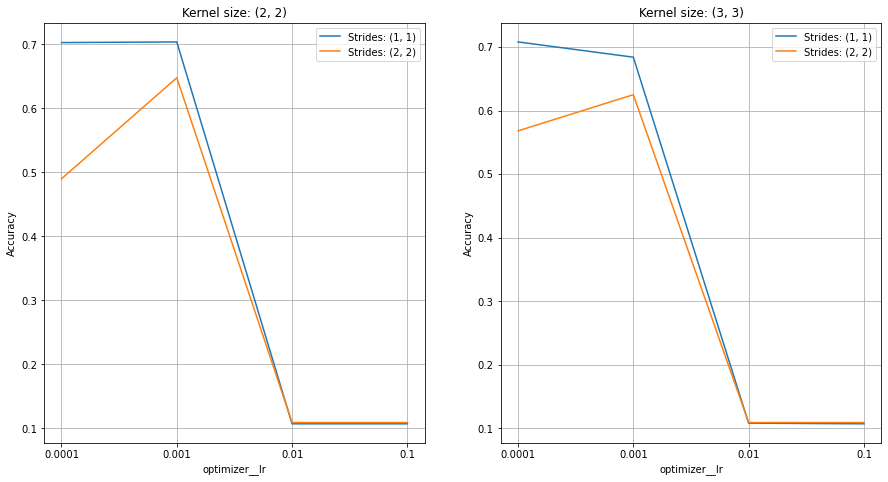

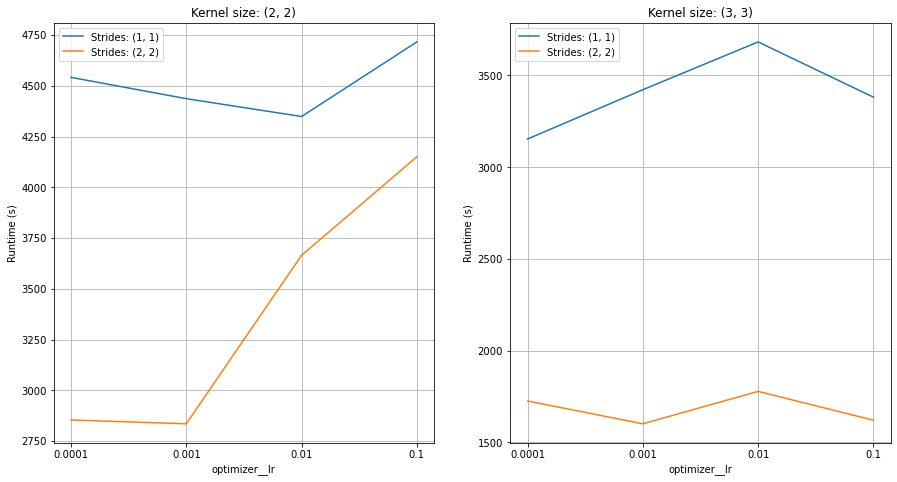

In [84]:
test_score_cnn = cnn_model.cv_results_["mean_test_score"].reshape(len(cnn_parameter_grid["kernel_size"]),
                                                                  len(cnn_parameter_grid["optimizer__lr"]),
                                                                  -1)

n_splits  = cnn_model.n_splits_ #number of splits of training data
n_iter = pd.DataFrame(cnn_model.cv_results_).shape[0] #Iterations per split
mean_fit_time = cnn_model.cv_results_['mean_fit_time'] * n_splits * n_iter
mean_fit_time = mean_fit_time.reshape(len(cnn_parameter_grid["kernel_size"]),
                                    len(cnn_parameter_grid["optimizer__lr"]),
                                    -1)
print("The best parameter is: ")
print(cnn_param)
cnn_plot(test_score_cnn, 15, 17, "Accuracy", "optimizer__lr")
cnn_plot(mean_fit_time, 15, 17, "Runtime (s)", "optimizer__lr")

## Final models

In this section, we are going to run our model using the parameters we found in the tuning section. We will record the running time and accuracy of the model.

### K-nearest neighbors (KNN)

In [66]:
# Build knn using the best hyperparameter
best_knn = KNeighborsClassifier(n_neighbors=knn_param["n_neighbors"])

# Record the runtime
knn_start = datetime.now()
best_knn.fit(X_train_pca, y_train_valid)
knn_end = datetime.now()

# Record the accuracy
knn_accuracy = best_knn.score(X_test_pca, y_test)
print("The accuracy of best KNN is: {}".format(knn_accuracy))
knn_diff = (knn_end - knn_start).total_seconds()

# 100 test examples
X_test_sample_pca = X_test_pca[:100]
X_test_sample = X_test[:100]
y_true_sample = y_test[:100]


The accuracy of best KNN is: 0.8604


In [67]:
# Get the F1 and Auc data
knn_y_proba = best_knn.predict(X_test_sample_pca)
knn_f1 = f1_score(y_true_sample, knn_y_proba, average="micro")
knn_fpr, knn_tpr, knn_thresholds = metrics.roc_curve(y_true_sample, knn_y_proba, pos_label=2)
knn_auc = metrics.auc(knn_fpr, knn_tpr)

### Fully connected neural network (MLP)

In [49]:
# Build the MLP using the best hyperparameter
best_mlp =  keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    # n_hidden_layer = 3, n_hidden_neurons = 100
    keras.layers.Dense(100, activation=mlp_param["activation_function"]),
    keras.layers.Dense(100, activation=mlp_param["activation_function"]),
    keras.layers.Dense(100, activation=mlp_param["activation_function"]),
    keras.layers.Dense(len(class_names), activation="softmax")
    ])

# The parameter depends on the variable
opt = keras.optimizers.SGD(learning_rate=mlp_param["optimizer__lr"])
best_mlp.compile(loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

In [50]:
# Record the training runtime
mlp_start = datetime.now()
history = best_mlp.fit(X_train_valid, y_train_valid, epochs = 30, validation_data = (X_valid, y_valid))
mlp_end = datetime.now()
mlp_diff = (mlp_end - mlp_start).total_seconds()

Epoch 1/30
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6383 - accuracy: 0.7780 - val_loss: 0.5052 - val_accuracy: 0.8253
Epoch 2/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4872 - accuracy: 0.8300 - val_loss: 0.5342 - val_accuracy: 0.8050
Epoch 3/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4592 - accuracy: 0.8387 - val_loss: 0.4702 - val_accuracy: 0.8318
Epoch 4/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4425 - accuracy: 0.8455 - val_loss: 0.4401 - val_accuracy: 0.8440
Epoch 5/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4345 - accuracy: 0.8475 - val_loss: 0.4812 - val_accuracy: 0.8275
Epoch 6/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4264 - accuracy: 0.8511 - val_loss: 0.5118 - val_accuracy: 0.8137
Epoch 7/30
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4218 - accuracy: 0.8533 - val_loss: 0.4518 - val_accuracy:

In [51]:
# Record the accuracy
mlp_loss, mlp_accuracy = best_mlp.evaluate(X_test_nor, y_test)
print(f"Accuracy of the best MLP: {mlp_accuracy:.4f}")

313/313 [==============================] - 0s 1ms/step - loss: 0.4435 - accuracy: 0.8440
Accuracy of the best MLP: 0.8440


#### Examples of prediction

4/4 [==============================] - 0s 2ms/step


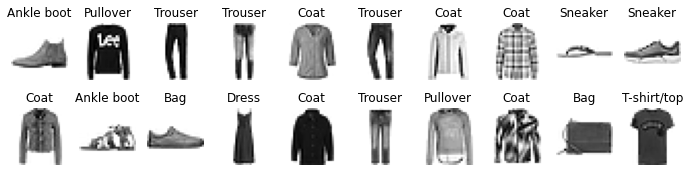

In [82]:
# Get the F1 and Auc data
# Show the prediction of first 20 examples
mlp_y_proba = best_mlp.predict(X_test_sample)
mlp_y_pred = np.argmax(mlp_y_proba, axis=-1)
plot_examples(X_test_sample, mlp_y_pred)
mlp_f1 = f1_score(y_true_sample, mlp_y_pred, average="micro")
mlp_fpr, mlp_tpr, mlp_thresholds = metrics.roc_curve(y_true_sample, mlp_y_pred, pos_label=2)
mlp_auc = metrics.auc(mlp_fpr, mlp_tpr)

### Convolutional neural network (CNN)

In [60]:
# Build the CNN using the best hyperparameter
best_cnn = keras.models.Sequential([
    
    keras.Input(shape = (28, 28, 1)),
    keras.layers.Conv2D(64, padding="same", kernel_size=cnn_param["kernel_size"], activation="relu"),
    keras.layers.Conv2D(64, padding="same", kernel_size=cnn_param["kernel_size"], activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides = cnn_param["strides"]),
    
    keras.layers.Conv2D(128, padding="same", kernel_size=(2, 2), activation="relu"),
    keras.layers.Conv2D(128, padding="same", kernel_size=(2, 2), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(256, padding="same", kernel_size=(2, 2), activation="relu"),
    keras.layers.Conv2D(256, padding="same", kernel_size=(2, 2), activation="relu"),
    keras.layers.Conv2D(256, padding="same", kernel_size=(2, 2), activation="relu"),    
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(512, padding="same", kernel_size=(2, 2), activation="relu"),
    keras.layers.Conv2D(512, padding="same", kernel_size=(2, 2), activation="relu"),
    keras.layers.Conv2D(512, padding="same", kernel_size=(2, 2), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4096, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation = "softmax")
    
])
opt = keras.optimizers.Adam(learning_rate=cnn_param["optimizer__lr"])
best_cnn.compile(loss="sparse_categorical_crossentropy",
                optimizer=opt,
                metrics=["accuracy"])

In [61]:
# Record the training runtime
cnn_start = datetime.now()
best_cnn.fit(X_train_valid, y_train_valid, epochs=30, batch_size=128, validation_data=(X_valid, y_valid))
cnn_end = datetime.now()
cnn_diff = (cnn_end - cnn_start).total_seconds()

Epoch 1/30
422/422 [==============================] - 23s 53ms/step - loss: 0.7077 - accuracy: 0.7273 - val_loss: 0.4323 - val_accuracy: 0.8333
Epoch 2/30
422/422 [==============================] - 19s 45ms/step - loss: 0.3768 - accuracy: 0.8599 - val_loss: 0.3583 - val_accuracy: 0.8693
Epoch 3/30
422/422 [==============================] - 18s 44ms/step - loss: 0.3123 - accuracy: 0.8842 - val_loss: 0.2944 - val_accuracy: 0.8875
Epoch 4/30
422/422 [==============================] - 19s 44ms/step - loss: 0.2745 - accuracy: 0.8993 - val_loss: 0.2809 - val_accuracy: 0.8950
Epoch 5/30
422/422 [==============================] - 18s 43ms/step - loss: 0.2466 - accuracy: 0.9090 - val_loss: 0.2917 - val_accuracy: 0.8933
Epoch 6/30
422/422 [==============================] - 19s 44ms/step - loss: 0.2259 - accuracy: 0.9161 - val_loss: 0.2669 - val_accuracy: 0.8992
Epoch 7/30
422/422 [==============================] - 18s 43ms/step - loss: 0.2039 - accuracy: 0.9245 - val_loss: 0.2543 - val_accuracy:

In [62]:
# Record the accuracy
cnn_loss, cnn_accuracy = best_cnn.evaluate(X_test_nor, y_test)
print(f"The accuracy of best CNN is {cnn_accuracy:.4f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.4443 - accuracy: 0.9194
The accuracy of best CNN is 0.9194


#### Examples of prediction

4/4 [==============================] - 0s 75ms/step


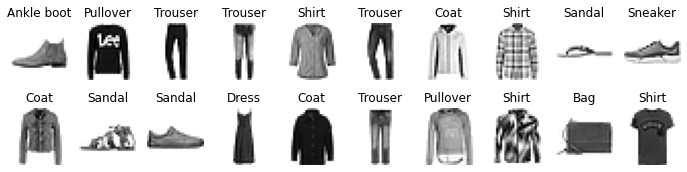

In [83]:
# Get the F1 and Auc data
# Show the prediction of first 20 examples
cnn_y_proba = best_cnn.predict(X_test_sample)
cnn_y_pred = np.argmax(cnn_y_proba, axis=-1)
plot_examples(X_test_sample, cnn_y_pred)
cnn_f1 = f1_score(y_true_sample, cnn_y_pred, average="micro")
cnn_fpr, cnn_tpr, cnn_thresholds = metrics.roc_curve(y_true_sample, cnn_y_pred, pos_label=2)
cnn_auc = metrics.auc(cnn_fpr, cnn_tpr)

## Result

In this section, we will compare the algorithms performance using running time and accuracy.

In [89]:
def plot_table(col_name, table_list, row_name):
    
    # Make the font size larger
    BIGGER_SIZE = 18
    plt.rc('font', size=BIGGER_SIZE)
    
    # Change the colors for the column and row names
    rcolors = plt.cm.BuPu(np.full(len(row_name), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(col_name), 0.1))
    
    # Plot the table
    table_plot = plt.table(
        cellText = algo_table,
        rowLabels=row_name,
        rowColours=rcolors,
        colLabels=col_name,
        colColours=ccolors,
        loc='center')
    
    # Remove the x axis, y axis and box
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.box(on=None)
    
    # Make the table larger
    table_plot.scale(3, 4)
    
    plt.title(
        label = "The comparison of Runtime, accuracy, F1 score and Auc between three algorithms",
        fontsize = 18,
        color = "blue")
    plt.xlabel("Knn: K = 6. MLP: Activation_function = None, Optimizer__lr = 0.01. CNN: kernel_size = (3, 3), Optimizer__lr = 0.0001, strides = (1, 1)")
    plt.show()
    return

The table shows that CNN has the highest accuracy and the KNN has the shortest training runing time.

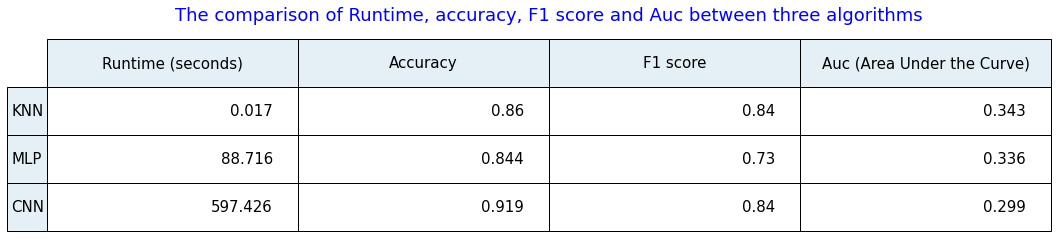

Knn: K = 6. 
MLP: Activation_function = None, Optimizer__lr = 0.01. 
CNN: kernel_size = (3, 3), Optimizer__lr = 0.0001, strides = (1, 1)


In [91]:
row_name = ["KNN", "MLP", "CNN"]
col_name = ["Runtime (seconds)", "Accuracy", "F1 score", "Auc (Area Under the Curve)"]
algo_table = [
    [round(knn_diff, 3), round(knn_accuracy, 3), round(knn_f1, 3), round(knn_auc, 3)], 
    [round(mlp_diff, 3), round(mlp_accuracy, 3), round(mlp_f1, 3), round(mlp_auc, 3)], 
    [round(cnn_diff, 3), round(cnn_accuracy, 3), round(cnn_f1, 3), round(cnn_auc, 3)]
    ]

plot_table(col_name, algo_table, row_name)
print("Knn: K = 6. \nMLP: Activation_function = None, Optimizer__lr = 0.01. \nCNN: kernel_size = (3, 3), Optimizer__lr = 0.0001, strides = (1, 1)")

From the above table we can see that KNN has the shortest running time and has the second highest accuracy, the best F1 score and Auc. MLP has the second longest running time, worst accuracy, F1 score and Auc among the three algorithms. CNN has the highest accuracy, longest running time, good F1 score and Auc.  
Therefore, we do not recommend using our MLP in this task. If running time is considered, we recommend using the KNN algorithm. If accuracy is considered, we recommend using the CNN algorithm.